# Initialize Functions

In [ ]:
#Naming conventions
#unod represents unod3d and unod2d does not exist due to one node indexing system; always a 1d vector
#u2d and u3d represent uele2d and uele3d in short; each has four columns (first as field; rest as gradient vector)

#Unsolved
#distance scaling factor does not work for coupled problems
#set_first_kind_bc needs to be updated to accomendate more rows in K

## Main functions

In [13]:
%reset -f

import copy,h5py,time
import numpy as np
import numpy.matlib
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import block_diag

#set physicsical constants
echarge=1.602e-19 #elementary charge [C]
perm0=8.85e-12 #vacuum permittivity [F/m]
kA=6.022e23 #Avogadro constant [1/mol]
kB=1.381e-23 #Boltzmann's constant [J/K]

def system_check():
    print('Run system check')
    print('Default numpy.int is %d bits'%np.iinfo(int).bits)
    print('Default numpy.float is %d bits'%np.finfo(float).bits)
    print('')
    return

def import_mesh(infile):
    print('Reading group mesh from %s'%infile)
    with h5py.File(infile,'r') as file:
        nodes=np.array(file['mesh/nodes']).astype(float)
        elements=np.array(file['mesh/elements']).astype(int)
        faces=np.array(file['mesh/faces']).astype(int)
        
        in_active_zones=np.array(file['mesh/in_active_zones']).astype(bool)
        with_first_kind_bc=np.array(file['mesh/with_first_kind_bc']).astype(bool)
        with_third_kind_bc=np.array(file['mesh/with_third_kind_bc']).astype(bool)

        in_electrolyte=np.array(file['mesh/in_electrolyte']).astype(bool)
        in_solid=np.array(file['mesh/in_solid']).astype(bool)
        in_stern=np.array(file['mesh/in_stern']).astype(bool)

    nind_e=np.unique(elements[in_active_zones,:].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_e))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',np.count_nonzero(with_first_kind_bc))
    print('THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',np.count_nonzero(with_third_kind_bc))
    print('')

    mesh={'elements':elements,'nodes':nodes,'faces':faces,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern}

    return mesh

def import_physics(infile):
    print('Reading group physics from %s'%infile)
    with h5py.File(infile,'r') as file:
        rel_perm_electrolyte=np.array(file['physics/rel_perm_electrolyte']).astype(float)
        rel_perm_solid=np.array(file['physics/rel_perm_solid']).astype(float)
        diffusion_electrolyte=np.array(file['physics/diffusion_electrolyte']).astype(float)
        diffusion_stern=np.array(file['physics/diffusion_stern']).astype(float)
        mobility_electrolyte=np.array(file['physics/mobility_electrolyte']).astype(float)
        mobility_stern=np.array(file['physics/mobility_stern']).astype(float)
        sigma_electrolyte=np.array(file['physics/sigma_electrolyte']).astype(float)
        sigma_stern=np.array(file['physics/sigma_stern']).astype(float)
        temp_K=np.array(file['physics/temperature']).astype(float)
        cinf=np.array(file['physics/ion_conc_inf']).astype(float)
        zval=np.array(file['physics/ion_val']).astype(float)

    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',sigma_electrolyte)
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',sigma_stern)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('')

    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
             'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
             'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
             'sigma_electrolyte':sigma_electrolyte,'sigma_stern':sigma_stern,
             'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval}

    return physics

def scale_mesh(mesh_in,dist_factor):
    print('Scaling distance in mesh')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    mesh=copy.deepcopy(mesh_in)
    mesh['nodes']=mesh['nodes']*dist_factor
    return mesh

def scale_materials(materials_in,dist_factor):
    print('Scaling distance in materials')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    materials=copy.deepcopy(materials_in)

    materials['cx']=materials['cx']/1.0
    materials['cy']=materials['cy']/1.0
    materials['cz']=materials['cz']/1.0

    materials['alpha_x']=materials['alpha_x']/dist_factor
    materials['alpha_y']=materials['alpha_y']/dist_factor
    materials['alpha_z']=materials['alpha_z']/dist_factor

    materials['beta_x']=materials['beta_x']/dist_factor
    materials['beta_y']=materials['beta_y']/dist_factor
    materials['beta_z']=materials['beta_z']/dist_factor

    materials['gamma_x']=materials['gamma_x']/dist_factor
    materials['gamma_y']=materials['gamma_y']/dist_factor
    materials['gamma_z']=materials['gamma_z']/dist_factor

    materials['a']=materials['a']/dist_factor**2
    materials['f']=materials['f']/dist_factor**2
    materials['gs']=materials['gs']/dist_factor
    materials['qs']=materials['qs']/dist_factor
    materials['snod']=materials['snod']/1.0
    materials['anod']=materials['anod']/dist_factor**2
    materials['fnod']=materials['fnod']/dist_factor**2

    return materials

def grad2d(nodes,faces,unod,dist_factor,local):
    print('Computing fields and gradients on faces')
    start=time.time()

    nface=len(faces)
    u2d=np.zeros((nface,7),dtype=complex)
    Je=np.ones((3,3))
    for i in range(nface): #consider parallelization
        nind=faces[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T

        Je[1:,:]=nodes_new[:,:-1].T
        invJe=np.linalg.inv(Je)

        xr=sum(nodes_new[:,0])/3
        yr=sum(nodes_new[:,1])/3
        u2d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr)*unod[nind])

        dudx=sum(unod[nind]*invJe[:,1])
        dudy=sum(unod[nind]*invJe[:,2])
        u2d[i,1:4]=[dudx,dudy,0]
        u2d[i,4:7]=np.linalg.inv(R).dot([dudx,dudy,0])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')

    if local:
        u2d=u2d[:,[0,1,2,3]]
    else:
        u2d=u2d[:,[0,4,5,6]]

    return u2d*dist_factor

def grad3d(nodes,elements,unod,dist_factor):
    print('Computing fields and gradients in elements')
    start=time.time()

    nelem=len(elements)
    u3d=np.zeros((nelem,4),dtype=complex)
    Je=np.ones((4,4))
    for i in range(nelem): #consider parallelization
        nind=elements[i,:]
        Je[1:,:]=nodes[nind,:].T
        invJe=np.linalg.inv(Je)

        xr=.25*sum(nodes[nind,0])
        yr=.25*sum(nodes[nind,1])
        zr=.25*sum(nodes[nind,2])
        u3d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr+invJe[:,3]*zr)*unod[nind])
        u3d[i,1]=sum(unod[nind]*invJe[:,1])
        u3d[i,2]=sum(unod[nind]*invJe[:,2])
        u3d[i,3]=sum(unod[nind]*invJe[:,3])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return u3d*dist_factor

def rotate_triangle(nodes):
    A=np.zeros((3,3))
    R=np.zeros((3,3))

    xnod=nodes[:,0]
    ynod=nodes[:,1]
    znod=nodes[:,2]

    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2

    n=n/np.linalg.norm(n)
    z=np.array([0,0,1])
    k=np.cross(n,z)
    norm_k=np.linalg.norm(k)
    if norm_k>1e-8: #consider improving this line
        k=k/norm_k

        cosb=np.dot(n,z)
        sinb=np.sqrt(1-cosb**2)

        A[0,:]=[0,-k[2],k[1]]
        A[1,:]=[k[2],0,-k[0]]
        A[2,:]=[-k[1],k[0],0]
        R=np.eye(3)+A.dot(sinb)+A.dot(A.dot(1-cosb))
    else:
        R=np.eye(3)

    return R

def output_unod(nodes,unod,srvfile):
    output=np.genfromtxt(srvfile,skip_header=1)
    rec=output[:,1:4]
    for i in range(len(rec)):
        dist2=(rec[i,0]-nodes[:,0])**2+(rec[i,1]-nodes[:,1])**2+(rec[i,2]-nodes[:,2])**2
        nind=np.argmin(dist2)
        output[i,6]=np.real(unod[nind])
        output[i,7]=np.imag(unod[nind])

    outfile=srvfile+'.out'
    fmt='%d\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e'
    print('Saving results to %s'%outfile)
    np.savetxt(outfile,output,header=str(len(output)),comments='',fmt=fmt)
    print('')
    return output

def assemble_Ke2d3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (2/2)')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    faces_stern=mesh['faces'][in_stern]
    nnode=len(mesh['nodes'])
    nface_stern=len(faces_stern)

    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nface_stern,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_stern],(nface_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_stern*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nface_stern):
        nind=faces_stern[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        ynod=nodes_new[:,1]
        Ke,be=build_Ke2d3d(xnod,ynod,gamma_x=gamma_x[i],
                           gamma_y=gamma_y[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ks3d2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (1/2)')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc'] #identical to in_stern

    nodes=mesh['nodes']
    faces_bc=mesh['faces'][with_third_kind_bc,:]
    nnode=len(nodes)
    nface_bc=len(faces_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nface_bc,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_bc*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nface_bc):
        nind=faces_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks3d2d(xnod,ynod,znod,gs=gs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ke2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    faces_stern=mesh['faces'][in_stern]
    nnode=len(mesh['nodes'])
    nface_stern=len(faces_stern)

    cx=np.reshape(materials['cx'][in_stern],(nface_stern,nrep,nrep))
    cy=np.reshape(materials['cy'][in_stern],(nface_stern,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_stern],(nface_stern,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_stern],(nface_stern,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_stern],(nface_stern,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_stern],(nface_stern,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nface_stern,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_stern],(nface_stern,nrep))
    a=np.reshape(materials['a'][in_stern],(nface_stern,nrep,nrep))
    f=np.reshape(materials['f'][in_stern],(nface_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_stern*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nface_stern):
        nind=faces_stern[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        ynod=nodes_new[:,1]
        Ke,be=build_Ke2d(xnod,ynod,cx=cx[i],cy=cy[i],
                         alpha_x=alpha_x[i],alpha_y=alpha_y[i],
                         beta_x=beta_x[i],beta_y=beta_y[i],
                         gamma_x=gamma_x[i],gamma_y=gamma_y[i],
                         a=a[i],f=f[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ke3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_active_zones=mesh['in_active_zones']

    nodes=mesh['nodes']
    elements_in=mesh['elements'][in_active_zones,:]
    nnode=len(mesh['nodes'])
    nelem_in=len(elements_in)

    cx=np.reshape(materials['cx'][in_active_zones],(nelem_in,nrep,nrep))
    cy=np.reshape(materials['cy'][in_active_zones],(nelem_in,nrep,nrep))
    cz=np.reshape(materials['cz'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_z=np.reshape(materials['alpha_z'][in_active_zones],(nelem_in,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_active_zones],(nelem_in,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_active_zones],(nelem_in,nrep,nrep))
    beta_z=np.reshape(materials['beta_z'][in_active_zones],(nelem_in,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_active_zones],(nelem_in,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_active_zones],(nelem_in,nrep))
    gamma_z=np.reshape(materials['gamma_z'][in_active_zones],(nelem_in,nrep))
    a=np.reshape(materials['a'][in_active_zones],(nelem_in,nrep,nrep))
    f=np.reshape(materials['f'][in_active_zones],(nelem_in,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    J=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    V=np.zeros(cnt+nelem_in*16*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(4*nrep),4*nrep,1).T
    COL=np.matlib.repmat(np.arange(4*nrep),4*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nelem_in):
        nind=elements_in[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ke,be=build_Ke3d(xnod,ynod,znod,cx=cx[i],cy=cy[i],cz=cz[i],
                         alpha_x=alpha_x[i],alpha_y=alpha_y[i],alpha_z=alpha_z[i],
                         beta_x=beta_x[i],beta_y=beta_y[i],beta_z=beta_z[i],
                         gamma_x=gamma_x[i],gamma_y=gamma_y[i],gamma_z=gamma_z[i],
                         a=a[i],f=f[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+16*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+16*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+16*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+16*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ks3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the boundary condition of the third kind')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc']

    nodes=mesh['nodes']
    faces_bc=mesh['faces'][with_third_kind_bc,:]
    nnode=len(nodes)
    nface_bc=len(faces_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nface_bc,nrep))
    qs=np.reshape(materials['qs'][with_third_kind_bc],(nface_bc,nrep,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_bc*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nface_bc):
        nind=faces_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks3d(xnod,ynod,znod,gs=gs[i],qs=qs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def set_first_kind_bc3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the Dirichlet boundary condition')
    start=time.time()
    with_first_kind_bc=mesh['with_first_kind_bc']

    nodes=mesh['nodes']
    nodes_bc=mesh['nodes'][with_first_kind_bc]
    nnode=len(nodes)
    nnode_bc=len(nodes_bc)
    snod=np.reshape(materials['snod'][with_first_kind_bc],(nnode_bc,nrep))

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_bc=np.where(with_first_kind_bc)[0]
    nind_in=np.where(~with_first_kind_bc)[0]

    for i in nind_in:
        rows=REP[i,:].flatten(order='C')+offset[0]
        cols=REP[nind_bc,:].flatten(order='C')+offset[1]
        for j in np.asmatrix(rows).T: #to be compatible if rows is a scalar
            b[j]=b[j]-K[j,cols].dot(snod.flatten(order='C'))

    rows=REP[nind_bc,:].flatten(order='C')+offset[0]
    cols=REP[nind_bc,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0
    K=zero_rows(K,rows)
    K=zero_cols(K,cols)
    b[rows]=snod.flatten(order='C')

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes2d(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    faces=mesh['faces']
    in_stern=mesh['in_stern']
    nnode=len(mesh['nodes'])

    nind_stern=np.unique(faces[in_stern].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_stern]=0

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_out=np.where(mask_inactive)[0]

    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes3d(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    elements=mesh['elements']
    in_active_zones=mesh['in_active_zones']
    nnode=len(mesh['nodes'])

    nind_in=np.unique(elements[in_active_zones].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_in]=False

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    nind_out=np.where(mask_inactive)[0]

    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def build_Ke2d3d(xnod,ynod,gamma_x,gamma_y,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
            #         +a[kk,ll]*(1+delta_ij)/12.0+
            #         (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
            #         (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0)*area
            Ke[i,j]=(gamma_x[kk]*invJe[ii,1]*invJe[jj,1]+
                     gamma_y[kk]*invJe[ii,2]*invJe[jj,2])*area*delta_kl
        #be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area

    return -Ke,be

def build_Ks3d2d(xnod,ynod,znod,gs,nrep=1):
    Ks=np.zeros((3*nrep,3*nrep),dtype=complex)
    bs=np.zeros(3*nrep,dtype=complex)

    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ks[i,j]=qs[kk,ll]*area*(1+delta_ij)/12.0
            #replace qs[kk,ll] above with gs[kk]*delta_kl
            #gs[kk]*delta_kl is equivalent to qs[kk,ll]
            #in terms of indexing (both vary with kk and ll)
            Ks[i,j]=gs[kk]*delta_kl*area*(1+delta_ij)/12.0
        #bs[i]=gs[kk]*area/3
        #bs is a placeholder; unused

    #don't forget return -Ks instead of Ks
    return -Ks,bs

def build_Ke2d(xnod,ynod,cx,cy,alpha_x,alpha_y,beta_x,
               beta_y,gamma_x,gamma_y,a,f,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     +a[kk,ll]*(1+delta)/12.0+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0)*area
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area

    return Ke,be

def build_Ke3d(xnod,ynod,znod,cx,cy,cz,alpha_x,alpha_y,alpha_z,beta_x,
               beta_y,beta_z,gamma_x,gamma_y,gamma_z,a,f,nrep=1):
    Ke=np.zeros((4*nrep,4*nrep),dtype=complex)
    be=np.zeros(4*nrep,dtype=complex)
    Je=np.ones((4,4))
    Je[1,:]=xnod
    Je[2,:]=ynod
    Je[3,:]=znod
    invJe=np.linalg.inv(Je)
    vol=np.linalg.det(Je)/6.0

    for i in range(4*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3,4
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(4*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3,4
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     cz[kk,ll]*invJe[ii,3]*invJe[jj,3]+a[kk,ll]*(1+delta)/20.0+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2]+alpha_z[kk,ll]*invJe[ii,3])/4.0+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2]+beta_z[kk,ll]*invJe[jj,3])/4.0)*vol
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+gamma_z[kk]*invJe[ii,3]+f[kk]/4.0)*vol

    return Ke,be

def build_Ks3d(xnod,ynod,znod,gs,qs,nrep=1):
    Ks=np.zeros((3*nrep,3*nrep),dtype=complex)
    bs=np.zeros(3*nrep,dtype=complex)

    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ks[i,j]=qs[kk,ll]*area*(1+delta)/12.0
        bs[i]=gs[kk]*area/3.0

    return Ks,bs

def zero_rows(M,rows):
    diag=sparse.eye(M.shape[0]).tolil()
    for r in rows:
        diag[r,r]=0
    #diag[rows,rows]=0
    return diag.dot(M)

def zero_cols(M,cols):
    diag=sparse.eye(M.shape[0]).tolil()
    for c in cols:
        diag[c,c]=0
    #diag[cols,cols]=0
    return M.dot(diag)
    
def solve_unod(K,b):
    print('Calling sparse linear system solver')
    start=time.time()
    K.eliminate_zeros()
    sol=spsolve(K,b)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return sol

def reshape_unod(unod_in,nrep=1):
    nnode=int(len(unod_in)/nrep/2)
    unod=np.zeros((nnode,nrep*2),dtype=complex)
    unod[:,:nrep]=np.reshape(unod_in[:nnode*nrep],(nnode,nrep))
    unod[:,nrep:]=np.reshape(unod_in[nnode*nrep:],(nnode,nrep))
    return unod

def anso_slab(z,a,rel_perm,temp_K,cinf,zval,zeta,gradflag):
    print('Computing 1D linar PB solution in cartesian coordinates')
    perm=perm0*rel_perm
    ze=zval*echarge
    debye_len=np.sqrt(perm*kB*temp_K/2/ze**2/kA/cinf)
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    if gradflag:
        print('SURFACE CHARGE DENSITY AT INTERFACE IS:',zeta)
    else:
        print('POTENTIAL AT INTERFACE IS:',zeta)
    print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    print('')

    if gradflag:
        zeta=zeta*debye_len/perm0/rel_perm
        
    u=np.zeros((len(z),4))
    mask=z>=a
    u[mask,0]=zeta*np.exp(-z/debye_len)
    u[~mask,0]=zeta
    return u

def ansol_sphere(r,a,rel_perm,temp_K,cinf,zval,zeta,gradflag):
    print('Computing 1D linar PB solution in spherical coordinates')
    perm=perm0*rel_perm
    ze=zval*echarge
    debye_len=np.sqrt(perm*kB*temp_K/2/ze**2/kA/cinf)
    print('SOLID PARTICLE RADIUS IS:',a)
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    if gradflag:
        print('SURFACE CHARGE DENSITY AT SPHERE IS:',zeta)
    else:
        print('POTENTIAL AT SPHERE IS:',zeta)
    print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    print('')

    if gradflag:
        zeta=zeta/(1/debye_len+1/a)/perm0/rel_perm

    dist=np.sqrt(r[:,0]**2+r[:,1]**2+r[:,2]**2)
    u=np.zeros((len(dist),4))
    mask=dist>=a
    u[mask,0]=zeta*a*np.exp((a-dist[mask])/debye_len)/dist[mask]
    u[~mask,0]=zeta
    u[mask,1]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,0]/dist[mask]
    u[mask,2]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,1]/dist[mask]
    u[mask,3]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,2]/dist[mask]
    return u

def cartesian2spherical(x,y,z):
    rho=np.sqrt(x**2+y**2+z**2) #radial distance
    theta=np.arccos(z/rho) #polar angle
    #phi=np.arctan2(y/x)
    phi=np.zeros_like(rho)+np.pi/2 #azimuthal angle
    mask=x>0
    phi[mask]=np.arctan(y[mask]/x[mask])
    mask=x<0
    phi[mask]=np.arctan(y[mask]/x[mask])+np.pi
    return rho,theta,phi

def compute_tangent(nodes,faces,u2d_in):
    u2d=np.array(u2d_in)
    nface=len(faces)
    for i in range(len(faces)):
    #for i in range(1):
        nind=faces[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]

        a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
        b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
        n=np.cross(a,b)
        n=n/np.linalg.norm(n)

        normal=np.dot(u2d_in[i,1:],n)*n
        u2d[i,1:]=u2d_in[i,1:]-normal

    return u2d

def compute_mids2d(nodes,faces,dist_factor):
    #compute middle point of face element (efficiency to be improved)
    nface=len(faces[:,0])
    midpoints=np.zeros((nface,3))
    for i in range(0,nface):
        for j in range(0,3):
            midpoints[i,j]=sum(nodes[faces[i,:],j])/3

    return midpoints*dist_factor

def compute_mids3d(nodes,elements,dist_factor):
    #compute middle point of volume element (efficiency to be improved)
    nelem=len(elements[:,0])
    midpoints=np.zeros((nelem,3))
    for i in range(0,nelem):
        for j in range(0,3):
            midpoints[i,j]=.25*sum(nodes[elements[i,:],j])

    return midpoints*dist_factor

if __name__=='__main__':
    system_check()
    print('Done')

Run system check
Default numpy.int is 64 bits
Default numpy.float is 64 bits

Done


## Other functions

In [14]:
#https://gist.github.com/venuktan/8910385
import numpy as N
import scipy as S
def coo_submatrix_pull(matr, rows, cols):
    """
    Pulls out an arbitrary i.e. non-contiguous submatrix out of
    a sparse.coo_matrix. 
    """
    if type(matr) != S.sparse.coo_matrix:
        raise TypeError('Matrix must be sparse COOrdinate format')
    
    gr = -1 * N.ones(matr.shape[0])
    gc = -1 * N.ones(matr.shape[1])
    
    lr = len(rows)
    lc = len(cols)
    
    ar = N.arange(0, lr)
    ac = N.arange(0, lc)
    gr[rows[ar]] = ar
    gc[cols[ac]] = ac
    mrow = matr.row
    mcol = matr.col
    newelem = (gr[mrow] > -1) & (gc[mcol] > -1)
    newrows = mrow[newelem]
    newcols = mcol[newelem]
    return S.sparse.coo_matrix((matr.data[newelem], N.array([gr[newrows],
        gc[newcols]])),(lr, lc))

## Test surface gradients

Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Computing fields and gradients on faces
Time elapsed  2.6752758026123047 sec

Computing fields and gradients on faces
Time elapsed  2.6625616550445557 sec

Computing fields and gradients in elements
Time elapsed  4.485350608825684 sec



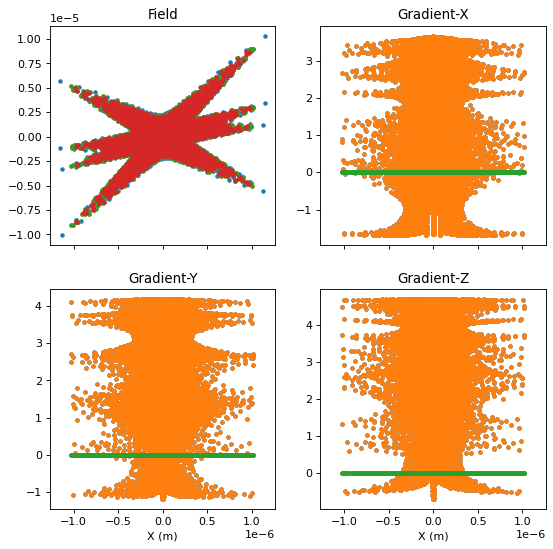

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

if __name__=='__main__':
    mesh=import_mesh('sphere_s61.hdf5')
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']

    unod=nodes[:,0]*2+nodes[:,1]*3+nodes[:,2]*4
    u2d_local=grad2d(nodes,faces,unod,dist_factor=1.0,local=True)
    u2d_global=grad2d(nodes,faces,unod,dist_factor=1.0,local=False)
    u2d_tangent=compute_tangent(nodes,faces,np.array([[0,2.0,3.0,4.0]]*len(faces)))
    u3d=grad3d(nodes,elements,unod,dist_factor=1.0)

    mids2d=compute_mids2d(nodes,faces,dist_factor=1.0)
    mids3d=compute_mids3d(nodes,elements,dist_factor=1.0)

    fig,ax=plt.subplots(2,2,sharex=True,figsize=(8,8),dpi=80)
    axs=ax.flatten()
    axs[0].plot(nodes[:,0],unod,'.')
    axs[0].plot(mids2d[:,0],np.real(u2d_local[:,0]),'.')
    axs[0].plot(mids2d[:,0],np.real(u2d_global[:,0]),'.')
    axs[0].plot(mids3d[:,0],np.real(u3d[:,0]),'.')
    axs[0].set_title('Field')

    axs[1].plot(mids2d[:,0],np.real(u2d_global[:,1]),'.')
    axs[1].plot(mids2d[:,0],np.real(u2d_tangent[:,1]),'.')
    axs[1].plot(mids2d[:,0],np.real(u2d_global[:,1]-u2d_tangent[:,1]),'.')
    axs[1].set_title('Gradient-X')

    axs[2].plot(mids2d[:,0],np.real(u2d_global[:,2]),'.')
    axs[2].plot(mids2d[:,0],np.real(u2d_tangent[:,2]),'.')
    axs[2].plot(mids2d[:,0],np.real(u2d_global[:,2]-u2d_tangent[:,2]),'.')
    axs[2].set_title('Gradient-Y')

    axs[3].plot(mids2d[:,0],np.real(u2d_global[:,3]),'.')
    axs[3].plot(mids2d[:,0],np.real(u2d_tangent[:,3]),'.')
    axs[3].plot(mids2d[:,0],np.real(u2d_global[:,3]-u2d_tangent[:,3]),'.')
    axs[3].set_title('Gradient-Z')

    axs[2].set_xlabel('X (m)')
    axs[3].set_xlabel('X (m)')
    plt.show()

# Decoupled Scalar Problem

In [ ]:
#dist_factor=1e9 passed test

## Template (DSP)

In [26]:
def set_materials2d(mesh,physics,u2d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])

    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']

    c=np.zeros(nface,dtype=complex)
    alpha_x=np.zeros(nface,dtype=complex)
    alpha_y=np.zeros(nface,dtype=complex)
    alpha_z=np.zeros(nface,dtype=complex)

    beta_x=np.zeros(nface,dtype=complex)
    beta_y=np.zeros(nface,dtype=complex)
    beta_z=np.zeros(nface,dtype=complex)

    gamma_x=np.zeros(nface,dtype=complex)
    gamma_y=np.zeros(nface,dtype=complex)
    gamma_z=np.zeros(nface,dtype=complex)

    a=np.zeros(nface,dtype=complex)
    f=np.zeros(nface,dtype=complex)
    gs=0 #placeholder; not implemented yet
    qs=0 #placeholder; not implemented yet
    snod=0 #placeholder; not implemented yet
    anod=0 #placeholder; not implemented yet
    fnod=0 #placeholder; not implemented yet

    c[in_stern]=physics['diffusion_stern']
    gamma_x[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_y[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_z[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    a[in_stern]=1j*freq

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}

    return materials
    
def set_materials3d(mesh,physics,u3d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])

    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']

    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']

    c=np.zeros(nelem,dtype=complex)
    alpha_x=np.zeros(nelem,dtype=complex)
    alpha_y=np.zeros(nelem,dtype=complex)
    alpha_z=np.zeros(nelem,dtype=complex)

    beta_x=np.zeros(nelem,dtype=complex)
    beta_y=np.zeros(nelem,dtype=complex)
    beta_z=np.zeros(nelem,dtype=complex)

    gamma_x=np.zeros(nelem,dtype=complex)
    gamma_y=np.zeros(nelem,dtype=complex)
    gamma_z=np.zeros(nelem,dtype=complex)

    a=np.zeros(nelem,dtype=complex)
    f=np.zeros(nelem,dtype=complex)
    gs=np.zeros(nface,dtype=complex)
    qs=np.zeros(nface,dtype=complex)
    snod=np.zeros(nnode,dtype=complex)
    anod=np.zeros(nnode,dtype=complex)
    fnod=np.zeros(nnode,dtype=complex)

    c[in_electrolyte]=perm0*physics['rel_perm_electrolyte']
    c[in_solid]=perm0*physics['rel_perm_solid']
    gs[in_stern]=-physics['sigma_electrolyte']

    ze=zval*echarge #ion valence times elementary charge
    u3d_scale=ze*u3d[:,0]/kB/temp_K #scaled potential in elements
    #a[:]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u3d_scale)
    #f[:]=-2*ze*kA*cinf*(np.sinh(u3d_scale)-np.cosh(u3d_scale)*u3d_scale)
    #a[in_solid]=0
    #f[in_solid]=0

    unod_scale=np.zeros(nnode)
    anod[:]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(unod_scale)
    fnod[:]=-2*ze*kA*cinf*(np.sinh(unod_scale)-np.cosh(unod_scale)*unod_scale)
    nind_solid=np.unique(elements[in_solid].flatten(order='C'))
    anod[nind_solid]=0
    fnod[nind_solid]=0

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}

    return materials

def build_system(mesh,materials2d,materials3d,case):
    nnode=len(mesh['nodes'])
    K=csr_matrix((nnode*2,nnode*2))
    b=np.zeros(nnode*2,dtype=complex)
    K,b=assemble_Ke3d(mesh,materials3d,K,b,offset=(0,0),nrep=1)
    K,b=assemble_Ks3d(mesh,materials3d,K,b,offset=(0,0),nrep=1)
    K,b=assemble_Ke2d(mesh,materials2d,K,b,offset=(nnode,nnode),nrep=1)
    K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode,nnode),nrep=1)

    return K,b

def assemble_Ke3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_active_zones=mesh['in_active_zones']
    
    nodes=mesh['nodes']
    elements_in=mesh['elements'][in_active_zones,:]
    nnode=len(mesh['nodes'])
    nelem_in=len(elements_in)
    
    cx=np.reshape(materials['cx'][in_active_zones],(nelem_in,nrep,nrep))
    cy=np.reshape(materials['cy'][in_active_zones],(nelem_in,nrep,nrep))
    cz=np.reshape(materials['cz'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_z=np.reshape(materials['alpha_z'][in_active_zones],(nelem_in,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_active_zones],(nelem_in,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_active_zones],(nelem_in,nrep,nrep))
    beta_z=np.reshape(materials['beta_z'][in_active_zones],(nelem_in,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_active_zones],(nelem_in,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_active_zones],(nelem_in,nrep))
    gamma_z=np.reshape(materials['gamma_z'][in_active_zones],(nelem_in,nrep))
    a=np.reshape(materials['a'][in_active_zones],(nelem_in,nrep,nrep))
    f=np.reshape(materials['f'][in_active_zones],(nelem_in,nrep))
    anod=np.reshape(materials['anod'],(nnode,nrep,nrep))
    fnod=np.reshape(materials['fnod'],(nnode,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    J=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    V=np.zeros(cnt+nelem_in*16*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(4*nrep),4*nrep,1).T
    COL=np.matlib.repmat(np.arange(4*nrep),4*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    
    for i in range(nelem_in):
        nind=elements_in[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ke,be=build_Ke3d(xnod,ynod,znod,cx=cx[i],cy=cy[i],cz=cz[i],
                         alpha_x=alpha_x[i],alpha_y=alpha_y[i],alpha_z=alpha_z[i],
                         beta_x=beta_x[i],beta_y=beta_y[i],beta_z=beta_z[i],
                         gamma_x=gamma_x[i],gamma_y=gamma_y[i],gamma_z=gamma_z[i],
                         a=a[i],f=f[i],anod=anod[nind],fnod=fnod[nind],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+16*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+16*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+16*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+16*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke3d(xnod,ynod,znod,cx,cy,cz,alpha_x,alpha_y,alpha_z,beta_x,
               beta_y,beta_z,gamma_x,gamma_y,gamma_z,a,f,anod,fnod,nrep=1):
    Ke=np.zeros((4*nrep,4*nrep),dtype=complex)
    be=np.zeros(4*nrep,dtype=complex)
    Je=np.ones((4,4))
    Je[1,:]=xnod
    Je[2,:]=ynod
    Je[3,:]=znod
    invJe=np.linalg.inv(Je)
    vol=np.linalg.det(Je)/6
    
    for i in range(4*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3,4
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(4*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3,4
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     cz[kk,ll]*invJe[ii,3]*invJe[jj,3]+a[kk,ll]*(1+delta)/20+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2]+alpha_z[kk,ll]*invJe[ii,3])/4+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2]+beta_z[kk,ll]*invJe[jj,3])/4+
                     anod[jj,kk,ll]*(1+delta)/20)*vol
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+gamma_z[kk]*invJe[ii,3]+f[kk]/4)*vol
        
        for jj in range(4):
            delta=1-np.abs(np.sign(ii-jj))
            be[i]=be[i]+fnod[jj,kk]*vol*(1+delta)/20
    
    return Ke,be

if __name__=='__main__':
    #user input
    meshfile='sphere_s61_electrolyte.hdf5'
    physfile='sphere_s61_electrolyte.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9

    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    u2d=np.zeros((len(mesh['faces']),4))
    u3d=np.zeros((len(mesh['elements']),4))
    materials2d=set_materials2d(mesh,physics,u2d,freq=0.1,case=1)
    materials3d=set_materials3d(mesh,physics,u3d,freq=0.1,case=1)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=1)

    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    unod=solve_unod(K/perm0,b/perm0)
    unod=reshape_unod(unod,nrep=1)
    output=output_unod(nodes,unod[:,0],srvfile)

    np.save('sphere_s61',unod)
    print('Done')

Reading group mesh from sphere_s61_electrolyte.hdf5
THE NUMBER OF ACTIVE NODES IS: 22705
THE NUMBER OF ACTIVE ELEMENTS IS: 123661
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61_electrolyte.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: -0.01
SURFACE CHARGE DENSITY FOR STERN LAYER IS: -0.01
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0

TEST CASE IS: 1
Setting material properties in Stern layer

TEST CASE IS: 1
Setting material properties in solid and electrolyte

Scaling distance in mesh
DISTANCE SCALING FACTOR IS: 1.00e+09

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+09



## Display (DSP)

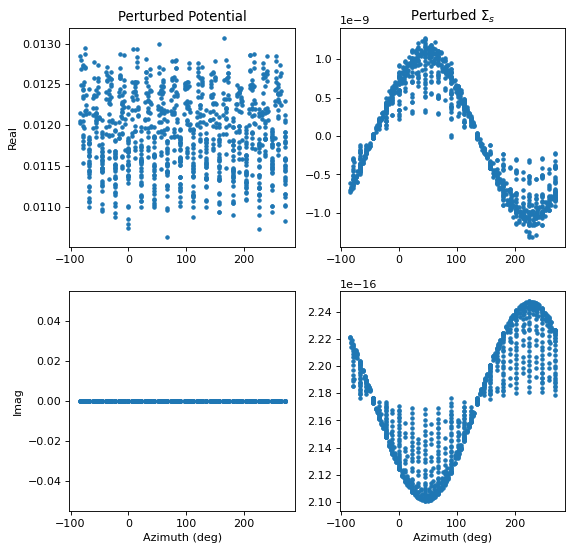

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Saving results to sphere_complex.srv.out



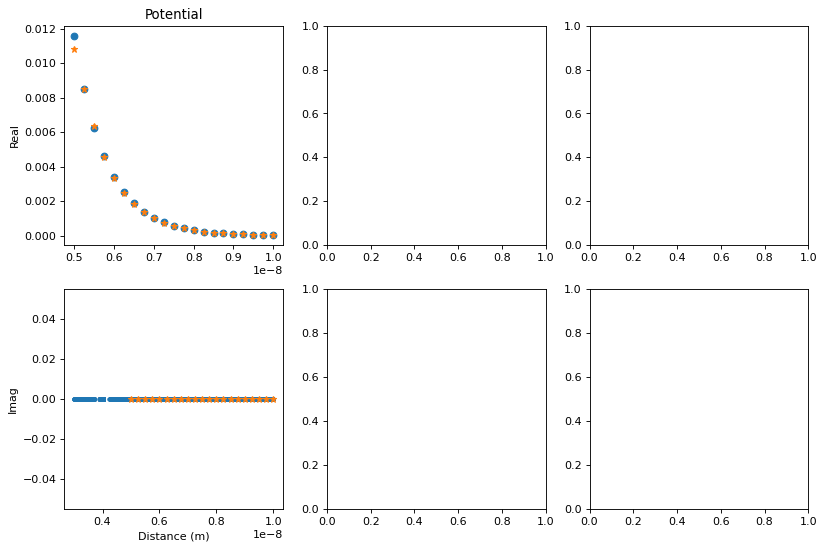

Computing fields and gradients in elements
Time elapsed  4.661024570465088 sec

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm



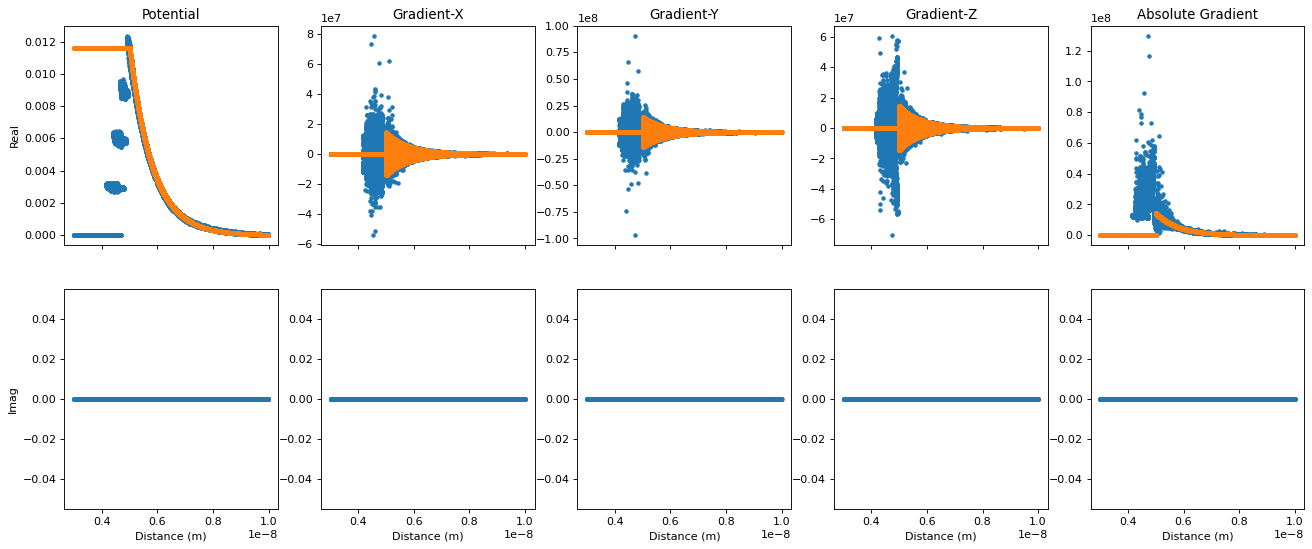

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

if __name__=='__main__':
    #first figure
    rho,theta,phi=cartesian2spherical(nodes[:,0],nodes[:,1],nodes[:,2])
    fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
    axs=ax.flatten()
    axs[0].plot(phi[nind_stern]*180/np.pi,np.real(unod[nind_stern,0]),'.')
    axs[1].plot(phi[nind_stern]*180/np.pi,np.real(unod[nind_stern,1]),'.')
    axs[2].plot(phi[nind_stern]*180/np.pi,np.imag(unod[nind_stern,0]),'.')
    axs[3].plot(phi[nind_stern]*180/np.pi,np.imag(unod[nind_stern,1]),'.')
    axs[0].set_title('Perturbed Potential')
    axs[1].set_title('Perturbed $\Sigma_s$')
    axs[2].set_xlabel('Azimuth (deg)')
    axs[3].set_xlabel('Azimuth (deg)')
    axs[0].set_ylabel('Real')
    axs[2].set_ylabel('Imag')
    plt.show()

    #second figure
    dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
    mask=(dist>3e-9)&(dist<1e-8)
    ansol=ansol_sphere(output[:,1:5],a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)
    fig,ax=plt.subplots(2,3,figsize=(12,8),dpi=80)
    titles=['Potential']
    axs=ax.flatten()
    for i in range(1):
        output=output_unod(nodes,unod[:,i],srvfile)
        axs[i].plot(output[:,1],ansol[:,0],'o')
        axs[i].plot(output[:,1],output[:,6],'*')
        axs[i].set_title(titles[i])

        axs[i+3].plot(dist[mask],np.imag(unod[mask,i]),'.')
        axs[i+3].plot(output[:,1],output[:,7],'*')
        axs[i+3].set_xlabel('Distance (m)')
    axs[0].set_ylabel('Real')
    axs[3].set_ylabel('Imag')
    plt.show()

    #third figure
    mids=compute_mids3d(nodes,elements,dist_factor=1.0)
    dist=np.sqrt(mids[:,0]**2+mids[:,1]**2+mids[:,2]**2)
    mask=(dist>3e-9)&(dist<1e-8)
    u3d=grad3d(nodes,elements,unod[:,0],dist_factor=1.0)
    u3d=np.append(u3d,np.asmatrix(np.sqrt(u3d[:,1]**2+u3d[:,2]**2+u3d[:,3]**2)).T,axis=1)
    ansol=ansol_sphere(mids,a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)
    ansol=np.append(ansol,np.asmatrix(np.sqrt(ansol[:,1]**2+ansol[:,2]**2+ansol[:,3]**2)).T,axis=1)
    titles=['Potential','Gradient-X','Gradient-Y','Gradient-Z','Absolute Gradient']
    fig,ax=plt.subplots(2,5,sharex=True,figsize=(20,8),dpi=80)
    axs=ax.flatten()
    for i in range(u3d.shape[1]):
        axs[i].plot(dist[mask],np.real(u3d[mask,i]),'.')
        axs[i].plot(dist[mask],ansol[mask,i],'.')
        axs[i].set_title(titles[i])

        axs[i+5].plot(dist[mask],np.imag(u3d[mask,i]),'.')
        axs[i+5].set_xlabel('Distance (m)')

    axs[0].set_ylabel('Real')
    axs[5].set_ylabel('Imag')
    plt.show()

# Decoupled Vector Problem

## Template (DVP)

In [24]:
def set_materials2d(mesh,physics,u2d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])

    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']

    c=np.zeros((nface,3,3),dtype=complex)
    alpha_x=np.zeros((nface,3,3),dtype=complex)
    alpha_y=np.zeros((nface,3,3),dtype=complex)
    alpha_z=np.zeros((nface,3,3),dtype=complex)

    beta_x=np.zeros((nface,3,3),dtype=complex)
    beta_y=np.zeros((nface,3,3),dtype=complex)
    beta_z=np.zeros((nface,3,3),dtype=complex)

    gamma_x=np.zeros((nface,3),dtype=complex)
    gamma_y=np.zeros((nface,3),dtype=complex)
    gamma_z=np.zeros((nface,3),dtype=complex)

    a=np.zeros((nface,3,3),dtype=complex)
    f=np.zeros((nface,3),dtype=complex)
    gs=0j #placeholder; not implemented yet
    qs=0j #placeholder; not implemented yet
    snod=0j #placeholder; not implemented yet
    anod=0j #placeholder;not implemented yet
    fnod=0j #placeholder; not implemented yet

    c[in_stern,2,2]=physics['diffusion_stern']
    gamma_x[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_y[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_z[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']
    a[in_stern,0,0]=1j*freq
    a[in_stern,1,1]=1j*freq
    a[in_stern,2,2]=1j*freq

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}

    return materials
    
def set_materials3d(mesh,physics,u3d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])

    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']

    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']

    c=np.zeros((nelem,3,3),dtype=complex)
    alpha_x=np.zeros((nelem,3,3),dtype=complex)
    alpha_y=np.zeros((nelem,3,3),dtype=complex)
    alpha_z=np.zeros((nelem,3,3),dtype=complex)

    beta_x=np.zeros((nelem,3,3),dtype=complex)
    beta_y=np.zeros((nelem,3,3),dtype=complex)
    beta_z=np.zeros((nelem,3,3),dtype=complex)

    gamma_x=np.zeros((nelem,3),dtype=complex)
    gamma_y=np.zeros((nelem,3),dtype=complex)
    gamma_z=np.zeros((nelem,3),dtype=complex)

    a=np.zeros((nelem,3,3),dtype=complex)
    f=np.zeros((nelem,3),dtype=complex)
    gs=np.zeros((nface,3),dtype=complex)
    qs=np.zeros((nface,3,3),dtype=complex)
    snod=np.zeros((nnode,3),dtype=complex)
    anod=np.zeros((nnode,3,3),dtype=complex)
    fnod=np.zeros((nnode,3),dtype=complex)

    c[in_electrolyte,2,2]=perm0*physics['rel_perm_electrolyte']
    c[in_solid,2,2]=perm0*physics['rel_perm_solid']
    gs[in_stern,2]=-physics['sigma_electrolyte']

    ze=zval*echarge #ion valence times elementary charge
    u3d_scale=ze*u3d[in_electrolyte,0]/kB/temp_K #scaled potential in elements
    #a[in_electrolyte,2,2]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u3d_scale)
    #f[in_electrolyte,2]=-2*ze*kA*cinf*(np.sinh(u3d_scale)-np.cosh(u3d_scale)*u3d_scale)
    #a[:,0,0]=1
    #a[:,1,1]=1
    
    unod_scale=np.zeros(nnode)
    anod[:,2,2]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(unod_scale)
    fnod[:,2]=-2*ze*kA*cinf*(np.sinh(unod_scale)-np.cosh(unod_scale)*unod_scale)
    nind_solid=np.unique(elements[in_solid].flatten(order='C'))
    anod[nind_solid,2,2]=0
    fnod[nind_solid,2]=0
    anod[:,0,0]=1
    anod[:,1,1]=1

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}

    return materials

def build_system(mesh,materials2d,materials3d,case):
    nnode=len(mesh['nodes'])
    K=csr_matrix((nnode*6,nnode*6))
    b=np.zeros(nnode*6,dtype=complex)
    K,b=assemble_Ke3d(mesh,materials3d,K,b,offset=(0,0),nrep=3)
    K,b=assemble_Ks3d(mesh,materials3d,K,b,offset=(0,0),nrep=3)
    K,b=assemble_Ke2d(mesh,materials2d,K,b,offset=(nnode*3,nnode*3),nrep=3)
    K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=3)
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=3)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode*3,nnode*3),nrep=3)

    return K,b

def assemble_Ke3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_active_zones=mesh['in_active_zones']
    
    nodes=mesh['nodes']
    elements_in=mesh['elements'][in_active_zones,:]
    nnode=len(mesh['nodes'])
    nelem_in=len(elements_in)
    
    cx=np.reshape(materials['cx'][in_active_zones],(nelem_in,nrep,nrep))
    cy=np.reshape(materials['cy'][in_active_zones],(nelem_in,nrep,nrep))
    cz=np.reshape(materials['cz'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_z=np.reshape(materials['alpha_z'][in_active_zones],(nelem_in,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_active_zones],(nelem_in,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_active_zones],(nelem_in,nrep,nrep))
    beta_z=np.reshape(materials['beta_z'][in_active_zones],(nelem_in,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_active_zones],(nelem_in,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_active_zones],(nelem_in,nrep))
    gamma_z=np.reshape(materials['gamma_z'][in_active_zones],(nelem_in,nrep))
    a=np.reshape(materials['a'][in_active_zones],(nelem_in,nrep,nrep))
    f=np.reshape(materials['f'][in_active_zones],(nelem_in,nrep))
    anod=np.reshape(materials['anod'],(nnode,nrep,nrep))
    fnod=np.reshape(materials['fnod'],(nnode,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    J=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    V=np.zeros(cnt+nelem_in*16*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(4*nrep),4*nrep,1).T
    COL=np.matlib.repmat(np.arange(4*nrep),4*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    
    for i in range(nelem_in):
        nind=elements_in[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ke,be=build_Ke3d(xnod,ynod,znod,cx=cx[i],cy=cy[i],cz=cz[i],
                         alpha_x=alpha_x[i],alpha_y=alpha_y[i],alpha_z=alpha_z[i],
                         beta_x=beta_x[i],beta_y=beta_y[i],beta_z=beta_z[i],
                         gamma_x=gamma_x[i],gamma_y=gamma_y[i],gamma_z=gamma_z[i],
                         a=a[i],f=f[i],anod=anod[nind],fnod=fnod[nind],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+16*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+16*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+16*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+16*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke3d(xnod,ynod,znod,cx,cy,cz,alpha_x,alpha_y,alpha_z,beta_x,
               beta_y,beta_z,gamma_x,gamma_y,gamma_z,a,f,anod,fnod,nrep=1):
    Ke=np.zeros((4*nrep,4*nrep),dtype=complex)
    be=np.zeros(4*nrep,dtype=complex)
    Je=np.ones((4,4))
    Je[1,:]=xnod
    Je[2,:]=ynod
    Je[3,:]=znod
    invJe=np.linalg.inv(Je)
    vol=np.linalg.det(Je)/6
    
    for i in range(4*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3,4
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(4*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3,4
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     cz[kk,ll]*invJe[ii,3]*invJe[jj,3]+a[kk,ll]*(1+delta)/20+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2]+alpha_z[kk,ll]*invJe[ii,3])/4+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2]+beta_z[kk,ll]*invJe[jj,3])/4+
                     anod[jj,kk,ll]*(1+delta)/20)*vol
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+gamma_z[kk]*invJe[ii,3]+f[kk]/4)*vol
        
        for jj in range(4):
            delta=1-np.abs(np.sign(ii-jj))
            be[i]=be[i]+fnod[jj,kk]*vol*(1+delta)/20
    
    return Ke,be

if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9

    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    u2d=np.zeros((len(mesh['faces']),4))
    u3d=np.zeros((len(mesh['elements']),4))
    materials2d=set_materials2d(mesh,physics,u2d,freq=0.1,case=2)
    materials3d=set_materials3d(mesh,physics,u3d,freq=0.1,case=2)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=2)

    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    unod=solve_unod(K/perm0,b/perm0)
    unod=reshape_unod(unod,nrep=3)
    output=output_unod(nodes,unod[:,0],srvfile)

    np.save('sphere_s61',unod)
    print('Done')

Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: -0.01
SURFACE CHARGE DENSITY FOR STERN LAYER IS: -0.01
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0

TEST CASE IS: 2
Setting material properties in Stern layer

TEST CASE IS: 2
Setting material properties in solid and electrolyte

Scaling distance in mesh
DISTANCE SCALING FACTOR IS: 1.00e+09

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+09

Scaling distance in mate

## Display (DVP)

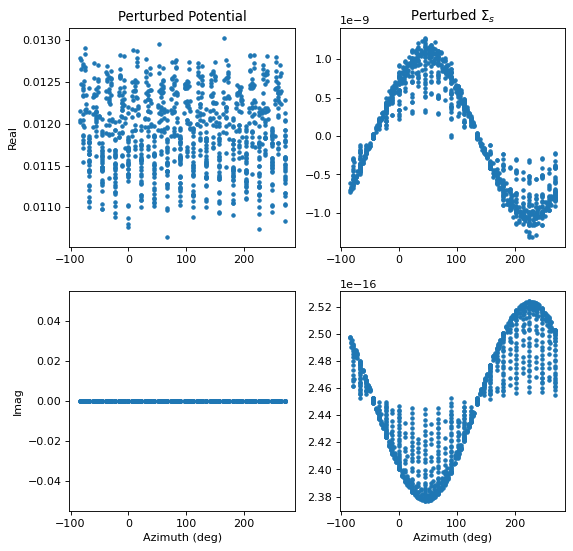

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out



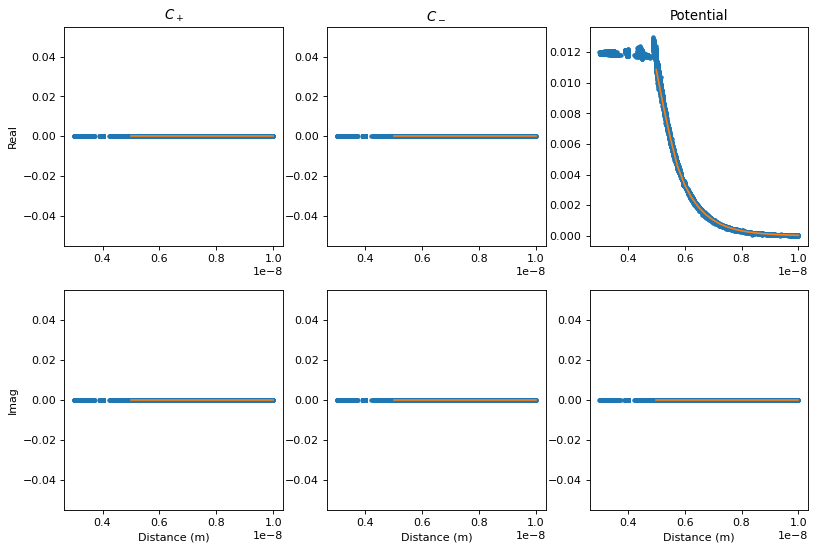

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

if __name__=='__main__':
    #first figure
    rho,theta,phi=cartesian2spherical(nodes[:,0],nodes[:,1],nodes[:,2])
    fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
    axs=ax.flatten()
    axs[0].plot(phi[nind_stern]*180/np.pi,np.real(unod[nind_stern,2]),'.')
    axs[1].plot(phi[nind_stern]*180/np.pi,np.real(unod[nind_stern,5]),'.')
    axs[2].plot(phi[nind_stern]*180/np.pi,np.imag(unod[nind_stern,2]),'.')
    axs[3].plot(phi[nind_stern]*180/np.pi,np.imag(unod[nind_stern,5]),'.')
    axs[0].set_title('Perturbed Potential')
    axs[1].set_title('Perturbed $\Sigma_s$')
    axs[2].set_xlabel('Azimuth (deg)')
    axs[3].set_xlabel('Azimuth (deg)')
    axs[0].set_ylabel('Real')
    axs[2].set_ylabel('Imag')
    plt.show()

    #second figure
    dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
    mask=(dist>3e-9)&(dist<1e-8)
    ansol=ansol_sphere(output[:,1:5],a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)
    fig,ax=plt.subplots(2,3,figsize=(12,8),dpi=80)
    titles=['$C_+$','$C_-$','Potential']
    axs=ax.flatten()
    for i in range(3):
        output=output_unod(nodes,unod[:,i],srvfile)
        axs[i].plot(dist[mask],np.real(unod[mask,i]),'.')
        axs[i].plot(output[:,1],output[:,6])
        axs[i].set_title(titles[i])

        axs[i+3].plot(dist[mask],np.imag(unod[mask,i]),'.')
        axs[i+3].plot(output[:,1],output[:,7])
        axs[i+3].set_xlabel('Distance (m)')
    axs[0].set_ylabel('Real')
    axs[3].set_ylabel('Imag')
    plt.show()

# (Placeholder)

# Test 5 (K12/K21)

In [ ]:
#dist_factor=1e9 was tested

## Run Simulation

In [ ]:
def set_materials2d(mesh,physics,u2d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
        
    c=np.zeros((nface,3,3),dtype=complex)
    alpha_x=np.zeros((nface,3,3),dtype=complex)
    alpha_y=np.zeros((nface,3,3),dtype=complex)
    alpha_z=np.zeros((nface,3,3),dtype=complex)

    beta_x=np.zeros((nface,3,3),dtype=complex)
    beta_y=np.zeros((nface,3,3),dtype=complex)
    beta_z=np.zeros((nface,3,3),dtype=complex)

    gamma_x=np.zeros((nface,3),dtype=complex)
    gamma_y=np.zeros((nface,3),dtype=complex)
    gamma_z=np.zeros((nface,3),dtype=complex)

    a=np.zeros((nface,3,3),dtype=complex)
    f=np.zeros((nface,3),dtype=complex)
    gs=0j #placeholder; not implemented yet
    qs=0j #placeholder; not implemented yet
    snod=0j #placeholder; not implemented yet
        
    c[in_stern,2,2]=physics['diffusion_stern']
    gamma_x[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern'] #coupled coefficient
    gamma_y[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern'] #coupled coefficient
    gamma_z[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern'] #coupled coefficient
    a[in_stern,0,0]=1j*freq
    a[in_stern,1,1]=1j*freq
    a[in_stern,2,2]=1j*freq
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    
    return materials

def set_materials3d(mesh,physics,u3d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    
    c=np.zeros((nelem,3,3),dtype=complex)
    alpha_x=np.zeros((nelem,3,3),dtype=complex)
    alpha_y=np.zeros((nelem,3,3),dtype=complex)
    alpha_z=np.zeros((nelem,3,3),dtype=complex)

    beta_x=np.zeros((nelem,3,3),dtype=complex)
    beta_y=np.zeros((nelem,3,3),dtype=complex)
    beta_z=np.zeros((nelem,3,3),dtype=complex)

    gamma_x=np.zeros((nelem,3),dtype=complex)
    gamma_y=np.zeros((nelem,3),dtype=complex)
    gamma_z=np.zeros((nelem,3),dtype=complex)

    a=np.zeros((nelem,3,3),dtype=complex)
    f=np.zeros((nelem,3),dtype=complex)
    gs=np.zeros((nface,3),dtype=complex)
    qs=np.zeros((nface,3,3),dtype=complex)
    snod=np.zeros((nnode,3),dtype=complex)
            
    c[in_electrolyte,0,0]=physics['diffusion_electrolyte']
    c[in_electrolyte,1,1]=physics['diffusion_electrolyte']
    c[in_electrolyte,2,2]=perm0*physics['rel_perm_electrolyte']

    c[in_electrolyte,0,2]=-physics['mobility_electrolyte']*cinf*np.exp(u3d[in_electrolyte,0]*echarge/kB/temp_K)
    c[in_electrolyte,1,2]=physics['mobility_electrolyte']*cinf*np.exp(-u3d[in_electrolyte,0]*echarge/kB/temp_K)

    c[in_solid,0,0]=0
    c[in_solid,1,1]=0
    c[in_solid,2,2]=perm0*physics['rel_perm_solid']

    alpha_x[in_electrolyte,0,0]=-physics['mobility_electrolyte']*u3d[in_electrolyte,1] #to be verified for vectors inside matrix
    alpha_y[in_electrolyte,0,0]=-physics['mobility_electrolyte']*u3d[in_electrolyte,2] #to be verified for vectors inside matrix
    alpha_z[in_electrolyte,0,0]=-physics['mobility_electrolyte']*u3d[in_electrolyte,3] #to be verified for vectors inside matrix

    alpha_x[in_electrolyte,1,1]=physics['mobility_electrolyte']*u3d[in_electrolyte,1] #to be verified for vectors inside matrix
    alpha_y[in_electrolyte,1,1]=physics['mobility_electrolyte']*u3d[in_electrolyte,2] #to be verified for vectors inside matrix
    alpha_z[in_electrolyte,1,1]=physics['mobility_electrolyte']*u3d[in_electrolyte,3] #to be verified for vectors inside matrix

    a[:,0,0]=1j*freq
    a[:,1,1]=1j*freq

    a[in_electrolyte,2,0]=kA*echarge
    a[in_electrolyte,2,1]=-kA*echarge

    gs[in_stern,0]=0 #coupled coefficient; need to verify sign
    gs[in_stern,1]=0 #coupled coefficient; need to verify sign
    gs[in_stern,2]=1 #coupled coefficient; need to verify sign

    nodes=mesh['nodes']
    with_first_kind_bc=mesh['with_first_kind_bc']
    snod[with_first_kind_bc,2]=nodes[with_first_kind_bc,0]*1e6 #need to be updated
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    
    return materials

def build_system(mesh,materials2d,materials3d,case=1):
    nnode=len(mesh['nodes'])
    mats3d_zero_gs=copy.deepcopy(materials3d)
    mats3d_zero_gs['gs'][:]=0

    mats2d_zero_gamma=copy.deepcopy(materials2d)
    mats2d_zero_gamma['gamma_x'][:]=0
    mats2d_zero_gamma['gamma_y'][:]=0
    mats2d_zero_gamma['gamma_z'][:]=0

    K=csr_matrix((nnode*6,nnode*6),dtype=complex)
    b=np.zeros(nnode*6,dtype=complex)
    K,b=assemble_Ke3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=3) #K11 element
    K,b=assemble_Ks3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=3) #K11 face
    K,b=assemble_Ke2d(mesh,mats2d_zero_gamma,K,b,offset=(nnode*3,nnode*3),nrep=3) #K22 element

    K,b=assemble_Ks3d2d(mesh,materials3d,K,b,offset=(0,nnode*3),nrep=3) #coupled term of K12
    K,b=assemble_Ke2d3d(mesh,materials2d,K,b,offset=(nnode*3,0),nrep=3) #coupled term of K12

    K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=3) #K11 1st kind b.c.
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=3)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode*3,nnode*3),nrep=3)
    
    return K,b

if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    #dist_factor=1e9
    dist_factor=1
    case=5
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    mids3d=compute_mids3d(mesh['nodes'],mesh['elements'])
    ansol=ansol_sphere(mids3d,a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)
    materials2d=set_materials2d(mesh,physics,u2d=0,freq=10,case=case)
    materials3d=set_materials3d(mesh,physics,u3d=ansol,freq=10,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    unod=solve_unod(K,b)
    unod=reshape_unod(unod,nrep=3)
    output=output_unod(nodes,unod[:,0],srvfile)
    
    K1=copy.deepcopy(K)
    b1=copy.deepcopy(b)
    unod1=copy.deepcopy(unod)
    np.save('sphere_s61',unod)
    print('Done')

Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS: 0.02
SURFACE CHARGE DENSITY FOR STERN LAYER IS: -0.01
SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: -0.01

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT

## Validate Results

K66 nind: [ 72473  72476  72479 ... 144935 144938 144941]
K65 nind: [ 72472  72475  72478 ... 144934 144937 144940]
K64 nind: [ 72471  72474  72477 ... 144933 144936 144939]
K63 nind: [    2     5     8 ... 72464 72467 72470]
K62 nind: [    1     4     7 ... 72463 72466 72469]
K61 nind: [    0     3     6 ... 72462 72465 72468]

K65 max(real) max(imag): 0.0 0.0
K64 max(real) max(imag): 0.0 0.0
K62 max(real) max(imag): 0.0 0.0
K61 max(real) max(imag): 0.0 0.0

Calling sparse linear system solver
Time elapsed  0.008851289749145508 sec



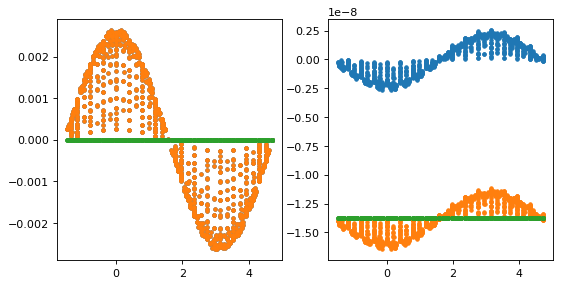

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt

def test(K_in,b_in):
    K=copy.deepcopy(K_in)
    b=copy.deepcopy(b_in)
    
    nnode=len(nodes)
    nind=np.arange(0,nnode*3,3)+nnode*3+2
    print('K66 nind:',nind)
    print('K65 nind:',nind-1)
    print('K64 nind:',nind-2)
    print('K63 nind:',nind-nnode*3)
    print('K62 nind:',nind-nnode*3-1)
    print('K61 nind:',nind-nnode*3-2)
    print('')
    K66=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind).tocsr()
    K65=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind-1).tocsr()
    K64=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind-2).tocsr()
    K63=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind-nnode*3).tocsr()
    K62=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind-nnode*3-1).tocsr()
    K61=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind-nnode*3-2).tocsr()
    
    b6=np.zeros(nnode,dtype=complex)
    #b6[:]=b[nind]-K63*unod1[:,2]
    b6[:]=(b6[:]-K65*unod[:,4]-K64*unod[:,3]-K63*unod[:,2]-
           K62*unod[:,1]-K61*unod[:,0])
    print('K65 max(real) max(imag):',np.max(np.abs(np.real(K65))),np.max(np.abs(np.imag(K65))))
    print('K64 max(real) max(imag):',np.max(np.abs(np.real(K64))),np.max(np.abs(np.imag(K64))))
    print('K62 max(real) max(imag):',np.max(np.abs(np.real(K62))),np.max(np.abs(np.imag(K62))))
    print('K61 max(real) max(imag):',np.max(np.abs(np.real(K61))),np.max(np.abs(np.imag(K61))))
    print('')
    
    unod6=solve_unod(K66,b6)
    rho,theta,phi=cartesian2spherical(nodes[nind_stern,0],nodes[nind_stern,1],nodes[nind_stern,2])
    fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
    axs=ax.flatten()
    axs[0].plot(phi,np.real(unod6[nind_stern]),'.')
    axs[0].plot(phi,np.real(unod1[nind_stern,-1]),'.')
    axs[0].plot(phi,np.real(unod1[nind_stern,-1]-unod6[nind_stern]),'.')
    axs[0].set_title('Perturbed Surface Charges')
    axs[0].set_xlabel('Azimuth (rad)')
    axs[0].set_ylabel('Real')
    
    axs[1].plot(phi,np.imag(unod6[nind_stern]),'.')
    axs[1].plot(phi,np.imag(unod1[nind_stern,-1]),'.')
    axs[1].plot(phi,np.imag(unod1[nind_stern,-1]-unod6[nind_stern]),'.')
    axs[1].set_title('Perturbed Surface Charges')
    axs[1].set_xlabel('Azimuth (rad)')
    axs[1].set_ylabel('Imag')
    plt.show()
    return

if __name__ == "__main__":
    test(K1,b1)

# Test 6 (Check Test 5 results)

## Run Simulation

In [95]:
def set_materials2d(mesh,physics,u2d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    c=np.zeros((nface,3,3),dtype=complex)
    alpha_x=np.zeros((nface,3,3),dtype=complex)
    alpha_y=np.zeros((nface,3,3),dtype=complex)
    alpha_z=np.zeros((nface,3,3),dtype=complex)

    beta_x=np.zeros((nface,3,3),dtype=complex)
    beta_y=np.zeros((nface,3,3),dtype=complex)
    beta_z=np.zeros((nface,3,3),dtype=complex)

    gamma_x=np.zeros((nface,3),dtype=complex)
    gamma_y=np.zeros((nface,3),dtype=complex)
    gamma_z=np.zeros((nface,3),dtype=complex)

    a=np.zeros((nface,3,3),dtype=complex)
    f=np.zeros((nface,3),dtype=complex)
    gs=0j #placeholder; not implemented yet
    qs=0j #placeholder; not implemented yet
    snod=0j #placeholder; not implemented yet

    c[in_stern,2,2]=physics['diffusion_stern']
    gamma_x[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']*u2d[in_stern,1]
    gamma_y[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']*u2d[in_stern,2]
    gamma_z[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']*u2d[in_stern,3]
    a[in_stern,0,0]=1j*freq
    a[in_stern,1,1]=1j*freq
    a[in_stern,2,2]=1j*freq

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    return materials

def set_materials3d(mesh,physics,u3d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']

    c=np.zeros((nelem,3,3),dtype=complex)
    alpha_x=np.zeros((nelem,3,3),dtype=complex)
    alpha_y=np.zeros((nelem,3,3),dtype=complex)
    alpha_z=np.zeros((nelem,3,3),dtype=complex)

    beta_x=np.zeros((nelem,3,3),dtype=complex)
    beta_y=np.zeros((nelem,3,3),dtype=complex)
    beta_z=np.zeros((nelem,3,3),dtype=complex)

    gamma_x=np.zeros((nelem,3),dtype=complex)
    gamma_y=np.zeros((nelem,3),dtype=complex)
    gamma_z=np.zeros((nelem,3),dtype=complex)

    a=np.zeros((nelem,3,3),dtype=complex)
    f=np.zeros((nelem,3),dtype=complex)
    gs=np.zeros((nface,3),dtype=complex)
    qs=np.zeros((nface,3,3),dtype=complex)
    snod=np.zeros((nnode,3),dtype=complex)

    c[in_electrolyte,2,2]=perm0*physics['rel_perm_electrolyte']
    c[in_solid,2,2]=perm0*physics['rel_perm_solid']
    a[:,0,0]=1j*freq
    a[:,1,1]=1j*freq
    gs[in_stern,0]=0
    gs[in_stern,1]=0
    gs[in_stern,2]=u3d[2][in_stern,0]
    f[in_electrolyte,2]=kA*echarge*(u3d[1][in_electrolyte,0]-u3d[0][in_electrolyte,0])

    nodes=mesh['nodes']
    with_first_kind_bc=mesh['with_first_kind_bc']
    snod[with_first_kind_bc,2]=nodes[with_first_kind_bc,0]*1e6 #need to be updated

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    return materials

def build_system(mesh,materials2d,materials3d,case=1):
    nnode=len(mesh['nodes'])
    K=csr_matrix((nnode*6,nnode*6))
    b=np.zeros(nnode*6,dtype=complex)
    K,b=assemble_Ke3d(mesh,materials3d,K,b,offset=(0,0),nrep=3)
    K,b=assemble_Ks3d(mesh,materials3d,K,b,offset=(0,0),nrep=3)
    K,b=assemble_Ke2d(mesh,materials2d,K,b,offset=(nnode*3,nnode*3),nrep=3)
    K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=3)
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=3)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode*3,nnode*3),nrep=3)
    
    return K,b

if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    #dist_factor=1e9
    dist_factor=1
    case=6
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    unod=np.load('sphere_s61_test5_1MV_new2.npy')
    u2d=grad2d(mesh['nodes'],mesh['faces'],unod[:,2])
    u3d=[grad3d(mesh['nodes'],mesh['elements'],unod[:,0]),
         grad3d(mesh['nodes'],mesh['elements'],unod[:,1]),
         grad2d(mesh['nodes'],mesh['faces'],unod[:,-1])]
    materials2d=set_materials2d(mesh,physics,u2d=u2d,freq=10,case=case)
    materials3d=set_materials3d(mesh,physics,u3d=u3d,freq=10,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #solution=solve_unod(K/perm0,b/perm0)
    unod=solve_unod(K,b)
    unod=reshape_unod(unod,nrep=3)
    output=output_unod(nodes,unod[:,0],srvfile)
    
    K2=copy.deepcopy(K)
    b2=copy.deepcopy(b)
    unod2=copy.deepcopy(unod)
    np.save('sphere_s61',unod)
    print('Done')

Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS: 0.02
SURFACE CHARGE DENSITY FOR STERN LAYER IS: -0.01
SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: -0.01

Computing fields and field gradients on faces
Time elapsed  2.986757278442383 sec

Computing fields and field gradients in elements
Time elapsed  5.422946453094482 sec

Computing fields and field gradients in elements
Time elapsed  4.

## Validate Results

Calling sparse linear system solver
Time elapsed  0.008812904357910156 sec



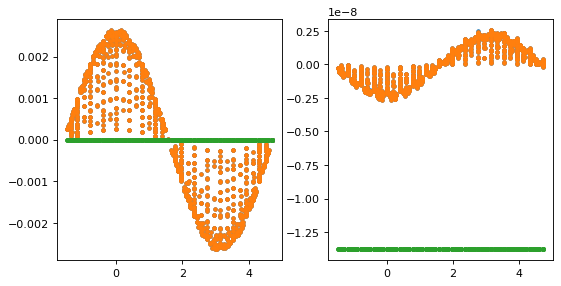

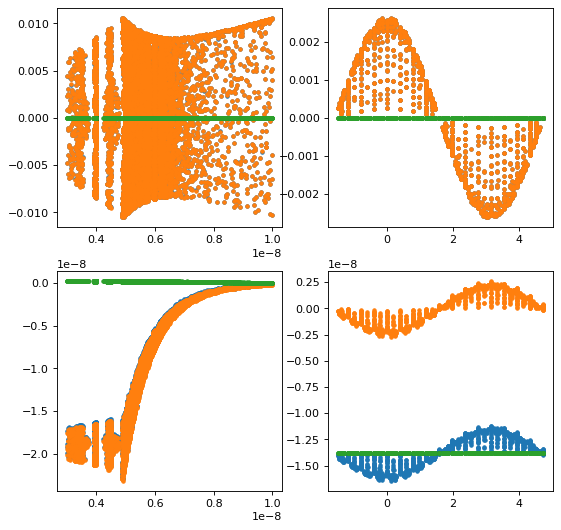

In [105]:
%matplotlib inline
import matplotlib.pyplot as plt

def test(K_in,b_in):
    K=copy.deepcopy(K_in)
    b=copy.deepcopy(b_in)
    
    nnode=len(nodes)
    nind=np.arange(0,nnode*3,3)+nnode*3+2
    K66=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind).tocsr()
    K63=coo_submatrix_pull(K.tocoo(),rows=nind,cols=nind-nnode*3).tocsr()
    
    b6=np.zeros(nnode,dtype=complex)
    b6[:]=b[nind]-K63*unod1[:,2]
    
    unod6=solve_unod(K66,b6)
    rho,theta,phi=cartesian2spherical(nodes[nind_stern,0],nodes[nind_stern,1],nodes[nind_stern,2])
    fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
    axs=ax.flatten()
    axs[0].plot(phi,np.real(unod6[nind_stern]),'.')
    axs[0].plot(phi,np.real(unod2[nind_stern,-1]),'.')
    axs[0].plot(phi,np.real(unod1[nind_stern,-1]-unod6[nind_stern]),'.')
    
    axs[1].plot(phi,np.imag(unod6[nind_stern]),'.')
    axs[1].plot(phi,np.imag(unod2[nind_stern,-1]),'.')
    axs[1].plot(phi,np.imag(unod1[nind_stern,-1]-unod6[nind_stern]),'.')
    plt.show()
    
    dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
    mask=(dist>3e-9)&(dist<1e-8)
    fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
    axs=ax.flatten()
    axs[0].plot(dist[mask],np.real(unod1[mask,2]),'.')
    axs[0].plot(dist[mask],np.real(unod2[mask,2]),'.')
    axs[0].plot(dist[mask],np.real(unod1[mask,2]-unod2[mask,2]),'.')
    
    axs[1].plot(phi,np.real(unod1[nind_stern,-1]),'.')
    axs[1].plot(phi,np.real(unod2[nind_stern,-1]),'.')
    axs[1].plot(phi,np.real(unod1[nind_stern,-1]-unod2[nind_stern,-1]),'.')
    
    axs[2].plot(dist[mask],np.imag(unod1[mask,2]),'.')
    axs[2].plot(dist[mask],np.imag(unod2[mask,2]),'.')
    axs[2].plot(dist[mask],np.imag(unod1[mask,2]-unod2[mask,2]),'.')
    
    axs[3].plot(phi,np.imag(unod1[nind_stern,-1]),'.')
    axs[3].plot(phi,np.imag(unod2[nind_stern,-1]),'.')
    axs[3].plot(phi,np.imag(unod1[nind_stern,-1]-unod2[nind_stern,-1]),'.')
    
    plt.show()
    return

if __name__ == "__main__":
    test(K1,b1)

# Test Case 7 Slab

## Build Mesh

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def set_mesh():
    #modify user inputs below
    mesh_prefix='slab'
    freq=[0.01,0.1,10] #simulating frequencies

    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=1,usecols=(1,2,3))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=1,usecols=5,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3,4),dtype='int')
    zones=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=5,dtype='int')

    print('Reading %s.1.face'%mesh_prefix)
    faces=np.genfromtxt(mesh_prefix+'.1.face',skip_header=1,usecols=(1,2,3),dtype='int')
    face_flags=np.genfromtxt(mesh_prefix+'.1.face',skip_header=1,usecols=4,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    faces=faces-1

    #scale nodes from meter to nano-meter
    nodes=nodes*1e-9
    
    nnode=len(nodes)
    nelem=len(elements)
    nface=len(faces)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF FACES IS: %d'%nface)
    print('')

    #define computational volume and boundaries
    in_active_zones=zones>=0 #True for elements used in computation
    with_first_kind_bc=(node_flags==1)|(node_flags==2) #True for nodes on first kind b.c.
    with_third_kind_bc=face_flags==40 #True for faces on third kind b.c.

    #define electrolyte,solid,stern layer
    in_air=(zones<=2)|(zones==6)
    in_electrolyte=zones==3
    in_solid=(zones==4)|(zones==5)
    in_stern=face_flags==40
    
    nind_e=np.unique(elements[in_active_zones,:].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_e))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',np.count_nonzero(with_first_kind_bc))
    print('THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',np.count_nonzero(with_third_kind_bc))
    print('')
    
    mesh={'elements':elements,'nodes':nodes,'faces':faces,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'in_air':in_air,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern}
    
    return mesh

def set_physics():
    rel_perm_electrolyte=78.5 #relative permittivity of bulk electrolyte [F/m]
    rel_perm_solid=4.5 #relative permittivity of solid particle [F/m]
    diffusion_electrolyte=2*1e-6**2/1e-3 #diffusion coefficient of water at 20 deg. C is 2*(1e-6*m)^2/(1e-3*s)
    diffusion_stern=2*1e-6**2/1e-2 #diffusion coefficient in Stern layer [m^2/s]
    mobility_electrolyte=5e-8 #mobility of sodium cation in bulk electrolyte [m^2/(Vs)]
    mobility_stern=5e-9 #mobility in Stern layer [m^2/(Vs)]
    sigma_electrolyte=0.0 #surface charge density in diffuse layer for steady state[C/m^2]
    sigma_stern=-0.01 #surface charge density in Stern layer for steady state[C/m^2]

    temp_K=298 #room/ambient temperature [K]
    cinf=100 #ion concentration in bulk electrolyte [mol/m^3]
    zval=1 #ion valence in bulk electrolyte
    # cinf_pos=0.01 #ion concentration of positive charges
    # cinf_neg=0.01 #ion concentration of negative charges
    # zval_pos=1 #positive ion valence
    # zval_neg=1 #negative ion valence

    print('Compute distance scaling factor using Debye length')
    debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    dist_factor=10**(-round(np.log10(debye_len))) #to be determined from debye length
    print('DEBYE LENGTH IS: %.2e m'%debye_len)
    print('SUGGESTED DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS:',-(sigma_stern+sigma_electrolyte))
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',sigma_stern)
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',sigma_electrolyte)
    print('')
    
    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
             'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
             'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
             'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval,
             'sigma_electrolyte':sigma_electrolyte,'sigma_stern':sigma_stern}
    
    return physics

if __name__ == "__main__":
    mesh=set_mesh()
    physics=set_physics()
    print('Done')

Reading slab.1.node
Reading slab.1.ele
Reading slab.1.face
THE NUMBER OF NODES IS: 7791
THE NUMBER OF ELEMENTS IS: 48439
THE NUMBER OF FACES IS: 9197

THE NUMBER OF ACTIVE NODES IS: 7791
THE NUMBER OF ACTIVE ELEMENTS IS: 48439
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 166
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2194

Compute distance scaling factor using Debye length
DEBYE LENGTH IS: 9.62e-10 m
SUGGESTED DISTANCE SCALING FACTOR IS: 1.00e+09

RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS: 0.01
SURFACE CHARGE DENSITY FOR STERN LAYER IS: -0.01
SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: 0.0

Done


## Run Simulation

In [3]:
def set_materials2d(mesh,physics,u2d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
        
    c=np.zeros(nface,dtype=complex)
    alpha_x=np.zeros(nface,dtype=complex)
    alpha_y=np.zeros(nface,dtype=complex)
    alpha_z=np.zeros(nface,dtype=complex)

    beta_x=np.zeros(nface,dtype=complex)
    beta_y=np.zeros(nface,dtype=complex)
    beta_z=np.zeros(nface,dtype=complex)

    gamma_x=np.zeros(nface,dtype=complex)
    gamma_y=np.zeros(nface,dtype=complex)
    gamma_z=np.zeros(nface,dtype=complex)

    a=np.zeros(nface,dtype=complex)
    f=np.zeros(nface,dtype=complex)
    gs=0 #placeholder; not implemented yet
    qs=0 #placeholder; not implemented yet
    snod=0 #placeholder; not implemented yet
    
    #c[in_stern]=physics['diffusion_stern']
    #gamma_x[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    #gamma_y[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    #gamma_z[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    #a[in_stern]=1j*freq
    a[in_stern]=1
    f[in_stern]=0.01
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    
    return materials
    
def set_materials3d(mesh,physics,u3d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_air=mesh['in_air']
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
        
    c=np.zeros(nelem,dtype=complex)
    alpha_x=np.zeros(nelem,dtype=complex)
    alpha_y=np.zeros(nelem,dtype=complex)
    alpha_z=np.zeros(nelem,dtype=complex)

    beta_x=np.zeros(nelem,dtype=complex)
    beta_y=np.zeros(nelem,dtype=complex)
    beta_z=np.zeros(nelem,dtype=complex)

    gamma_x=np.zeros(nelem,dtype=complex)
    gamma_y=np.zeros(nelem,dtype=complex)
    gamma_z=np.zeros(nelem,dtype=complex)

    a=np.zeros(nelem,dtype=complex)
    f=np.zeros(nelem,dtype=complex)
    gs=np.zeros(nface,dtype=complex)
    qs=np.zeros(nface,dtype=complex)
    snod=np.zeros(nnode,dtype=complex)
    
    c[in_air]=perm0
    c[in_electrolyte]=perm0
    c[in_solid]=perm0*physics['rel_perm_solid']
    gs[in_stern]=1
    
    #midpoints=compute_mids3d(mesh['nodes'],mesh['elements'],dist_factor=1)
    #eind=midpoints[:,-1]<0
    #c[eind]=perm0*physics['rel_perm_solid']
        
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    
    return materials

def build_system(mesh,materials2d,materials3d,case=1):
    nnode=len(mesh['nodes'])
    mats3d_zero_gs=copy.deepcopy(materials3d)
    mats3d_zero_gs['gs'][:]=0

    mats2d_zero_gamma=copy.deepcopy(materials2d)
    mats2d_zero_gamma['gamma_x'][:]=0
    mats2d_zero_gamma['gamma_y'][:]=0
    mats2d_zero_gamma['gamma_z'][:]=0

    K=csr_matrix((nnode*2,nnode*2),dtype=complex)
    b=np.zeros(nnode*2,dtype=complex)
    K,b=assemble_Ke3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=1) #K11 element
    K,b=assemble_Ks3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=1) #K11 face
    K,b=assemble_Ke2d(mesh,mats2d_zero_gamma,K,b,offset=(nnode*1,nnode*1),nrep=1) #K22 element

    K,b=assemble_Ks3d2d(mesh,materials3d,K,b,offset=(0,nnode*1),nrep=1) #coupled term of K12
    #K,b=assemble_Ke2d3d(mesh,materials2d,K,b,offset=(nnode*1,0),nrep=1) #coupled term of K12

    K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=1) #K11 1st kind b.c.
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode*1,nnode*1),nrep=1)
    
    return K,b

if __name__=='__main__':
    #user input
    #dist_factor=1e9
    dist_factor=1
    case=7
    
    #setup mesh and material properties
    u2d=np.zeros((len(mesh['faces']),4))
    u3d=np.zeros((len(mesh['elements']),4))
    materials2d=set_materials2d(mesh,physics,u2d=u2d,freq=0.1,case=case)
    materials3d=set_materials3d(mesh,physics,u3d=u3d,freq=0.1,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)

    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    unod=solve_unod(K/perm0,b/perm0)
    unod=reshape_unod(unod,nrep=1)    
    np.save('sphere_s71',unod)
    print('Done')

TEST CASE IS: 7
Setting material properties in Stern layer

TEST CASE IS: 7
Setting material properties in solid and electrolyte

Scaling distance in mesh
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Assembling the system of equations
Time elapsed  7.284735202789307 sec

Incoorprating the boundary condition of the third kind
Time elapsed  0.20063543319702148 sec

Assembling the system of equations
Time elapsed  0.5065822601318359 sec

Implementing coupled terms of the system of equations (1/2)
Time elapsed  0.24253535270690918 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  1.6472043991088867 sec

Setting the unkonwns on inactive nodes as zeros
Time elapsed  0.04945182800292969 sec

Setting the unkonwns on inactive nodes as zeros
Time elapsed  0.01566314697265625 sec

Calling sparse linear system solver
Time elapsed  2.911362648010254 sec

D

## Display Results

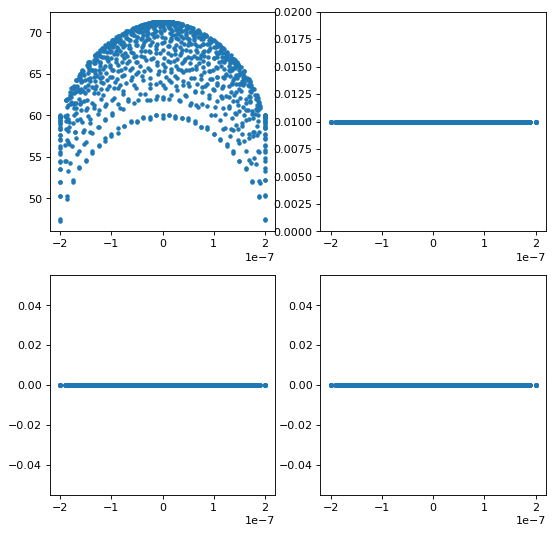

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

nrep=1

fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
axs=ax.flatten()
axs[0].plot(nodes[nind_stern,0],np.real(unod[nind_stern,nrep-1]),'.')
axs[1].plot(nodes[nind_stern,0],np.real(unod[nind_stern,nrep*2-1]),'.')
axs[1].set_ylim([0,0.02])

axs[2].plot(nodes[nind_stern,0],np.imag(unod[nind_stern,nrep-1]),'.')
axs[3].plot(nodes[nind_stern,0],np.imag(unod[nind_stern,nrep*2-1]),'.')

plt.show()

Saving results to slab_water.srv.out



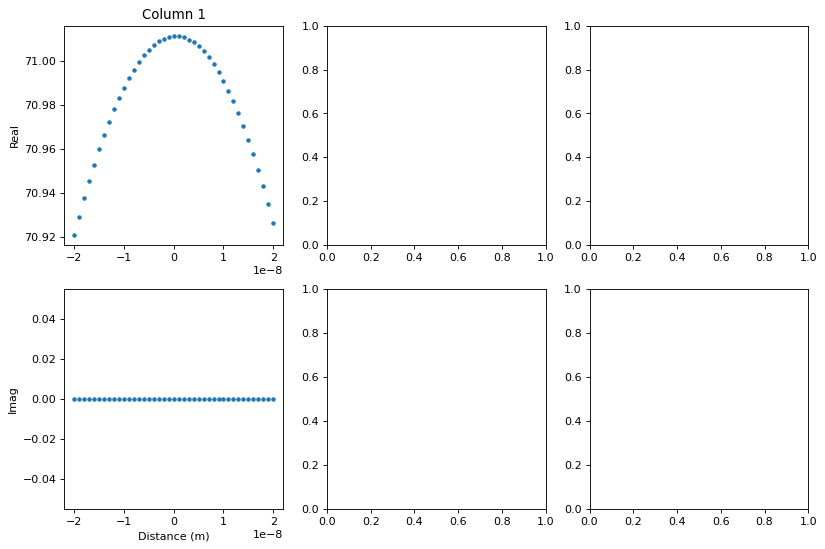

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

nrep=1

fig,ax=plt.subplots(2,3,figsize=(12,8),dpi=80)
axs=ax.flatten()
for i in range(nrep):
    output=output_unod(nodes,unod[:,i],'slab_water.srv')
    #axs[i].plot(nodes[:,0],np.real(unod[:,i]),'.')
    #axs[i].plot(output[:,1],ansol[:,0],'*')
    axs[i].plot(output[:,1],output[:,6],'.')
    axs[i].set_title('Column %d'%(i+1))
    axs[i].set_ylabel('Real')
    
    #axs[i+3].plot(nodes[:,0],np.imag(unod[:,i]),'.')
    axs[i+3].plot(output[:,1],output[:,7],'.')
    axs[i+3].set_xlabel('Distance (m)')
    axs[i+3].set_ylabel('Imag')

plt.show()

# Test Case 8 Slab

## Build Mesh

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def set_mesh():
    #modify user inputs below
    mesh_prefix='slab2'
    freq=[0.01,0.1,10] #simulating frequencies

    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=1,usecols=(1,2,3))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=1,usecols=5,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3,4),dtype='int')
    zones=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=5,dtype='int')

    print('Reading %s.1.face'%mesh_prefix)
    faces=np.genfromtxt(mesh_prefix+'.1.face',skip_header=1,usecols=(1,2,3),dtype='int')
    face_flags=np.genfromtxt(mesh_prefix+'.1.face',skip_header=1,usecols=4,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    faces=faces-1

    #scale nodes from meter to nano-meter
    nodes=nodes*1e-9
    
    nnode=len(nodes)
    nelem=len(elements)
    nface=len(faces)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF FACES IS: %d'%nface)
    print('')

    #define computational volume and boundaries
    in_active_zones=zones>=0 #True for elements used in computation
    with_first_kind_bc=node_flags==10 #True for nodes on first kind b.c.
    with_third_kind_bc=face_flags==40 #True for faces on third kind b.c.

    #define electrolyte,solid,stern layer
    in_air=(zones<=2)|(zones==6)
    in_electrolyte=zones==3
    in_solid=(zones==4)|(zones==5)
    in_stern=face_flags==40

#     nind=node_flags==10
#     tmp1=np.sort(nodes[nind,:])
#     nind=np.unique(faces[face_flags==10,:].flatten(order='C'))
#     tmp2=np.sort(nodes[nind,:])
#     print('node_flags==10',len(tmp1))
#     print('face_flags==10',len(tmp2))
#     print(np.max(np.abs(tmp1-tmp2)))
    
    nind_e=np.unique(elements[in_active_zones,:].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_e))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',np.count_nonzero(with_first_kind_bc))
    print('THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',np.count_nonzero(with_third_kind_bc))
    print('')
    
    mesh={'elements':elements,'nodes':nodes,'faces':faces,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'in_air':in_air,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern}
    
    return mesh

def set_physics():
    rel_perm_electrolyte=78.5 #relative permittivity of bulk electrolyte [F/m]
    rel_perm_solid=4.5 #relative permittivity of solid particle [F/m]
    diffusion_electrolyte=2*1e-6**2/1e-3 #diffusion coefficient of water at 20 deg. C is 2*(1e-6*m)^2/(1e-3*s)
    diffusion_stern=2*1e-6**2/1e-2 #diffusion coefficient in Stern layer [m^2/s]
    mobility_electrolyte=5e-8 #mobility of sodium cation in bulk electrolyte [m^2/(Vs)]
    mobility_stern=5e-9 #mobility in Stern layer [m^2/(Vs)]
    sigma_electrolyte=0.0 #surface charge density in diffuse layer for steady state[C/m^2]
    sigma_stern=-1.00 #surface charge density in Stern layer for steady state[C/m^2]

    temp_K=298 #room/ambient temperature [K]
    cinf=100 #ion concentration in bulk electrolyte [mol/m^3]
    zval=1 #ion valence in bulk electrolyte
    # cinf_pos=0.01 #ion concentration of positive charges
    # cinf_neg=0.01 #ion concentration of negative charges
    # zval_pos=1 #positive ion valence
    # zval_neg=1 #negative ion valence

    print('Compute distance scaling factor using Debye length')
    debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    dist_factor=10**(-round(np.log10(debye_len))) #to be determined from debye length
    print('DEBYE LENGTH IS: %.2e m'%debye_len)
    print('SUGGESTED DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS:',-(sigma_stern+sigma_electrolyte))
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',sigma_stern)
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',sigma_electrolyte)
    print('')
    
    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
             'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
             'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
             'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval,
             'sigma_electrolyte':sigma_electrolyte,'sigma_stern':sigma_stern}
    
    return physics

if __name__ == "__main__":
    mesh=set_mesh()
    physics=set_physics()
    print('Done')

Reading slab2.1.node
Reading slab2.1.ele
Reading slab2.1.face
THE NUMBER OF NODES IS: 63342
THE NUMBER OF ELEMENTS IS: 398843
THE NUMBER OF FACES IS: 72979

THE NUMBER OF ACTIVE NODES IS: 63342
THE NUMBER OF ACTIVE ELEMENTS IS: 398843
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 3138
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 18957

Compute distance scaling factor using Debye length
DEBYE LENGTH IS: 9.62e-10 m
SUGGESTED DISTANCE SCALING FACTOR IS: 1.00e+09

RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY FOR SOLID PARTICLE IS: 1.0
SURFACE CHARGE DENSITY FOR STERN LAYER IS: -1.0
SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: 0.0

Done


## Run Simulation

In [6]:
def assemble_Ke3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_active_zones=mesh['in_active_zones']
    
    nodes=mesh['nodes']
    elements_in=mesh['elements'][in_active_zones,:]
    nnode=len(mesh['nodes'])
    nelem_in=len(elements_in)
    
    cx=np.reshape(materials['cx'][in_active_zones],(nelem_in,nrep,nrep))
    cy=np.reshape(materials['cy'][in_active_zones],(nelem_in,nrep,nrep))
    cz=np.reshape(materials['cz'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_z=np.reshape(materials['alpha_z'][in_active_zones],(nelem_in,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_active_zones],(nelem_in,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_active_zones],(nelem_in,nrep,nrep))
    beta_z=np.reshape(materials['beta_z'][in_active_zones],(nelem_in,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_active_zones],(nelem_in,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_active_zones],(nelem_in,nrep))
    gamma_z=np.reshape(materials['gamma_z'][in_active_zones],(nelem_in,nrep))
    a=np.reshape(materials['a'][in_active_zones],(nelem_in,nrep,nrep))
    f=np.reshape(materials['f'][in_active_zones],(nelem_in,nrep))
    anod=np.reshape(materials['anod'],(nnode,nrep))
    fnod=np.reshape(materials['fnod'],(nnode,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    J=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    V=np.zeros(cnt+nelem_in*16*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(4*nrep),4*nrep,1).T
    COL=np.matlib.repmat(np.arange(4*nrep),4*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    
    for i in range(nelem_in):
        nind=elements_in[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ke,be=build_Ke3d(xnod,ynod,znod,cx=cx[i],cy=cy[i],cz=cz[i],
                         alpha_x=alpha_x[i],alpha_y=alpha_y[i],alpha_z=alpha_z[i],
                         beta_x=beta_x[i],beta_y=beta_y[i],beta_z=beta_z[i],
                         gamma_x=gamma_x[i],gamma_y=gamma_y[i],gamma_z=gamma_z[i],
                         a=a[i],f=f[i],fnod=fnod[nind],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+16*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+16*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+16*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+16*nrep**2
    
    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke3d(xnod,ynod,znod,cx,cy,cz,alpha_x,alpha_y,alpha_z,beta_x,
               beta_y,beta_z,gamma_x,gamma_y,gamma_z,a,f,fnod,nrep=1):
    Ke=np.zeros((4*nrep,4*nrep),dtype=complex)
    be=np.zeros(4*nrep,dtype=complex)
    Je=np.ones((4,4))
    Je[1,:]=xnod
    Je[2,:]=ynod
    Je[3,:]=znod
    invJe=np.linalg.inv(Je)
    vol=np.linalg.det(Je)/6
    
    for i in range(4*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3,4
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(4*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3,4
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     cz[kk,ll]*invJe[ii,3]*invJe[jj,3]+a[kk,ll]*(1+delta)/20+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2]+alpha_z[kk,ll]*invJe[ii,3])/4+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2]+beta_z[kk,ll]*invJe[jj,3])/4)*vol
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+gamma_z[kk]*invJe[ii,3]+f[kk]/4)*vol
        
        for jj in range(4):
            delta=1-np.abs(np.sign(ii-jj))
            be[i]=be[i]+fnod[jj,kk]*vol*(1+delta)/20
    
    return Ke,be

def set_materials2d(mesh,physics,u2d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
        
    c=np.zeros(nface,dtype=complex)
    alpha_x=np.zeros(nface,dtype=complex)
    alpha_y=np.zeros(nface,dtype=complex)
    alpha_z=np.zeros(nface,dtype=complex)

    beta_x=np.zeros(nface,dtype=complex)
    beta_y=np.zeros(nface,dtype=complex)
    beta_z=np.zeros(nface,dtype=complex)

    gamma_x=np.zeros(nface,dtype=complex)
    gamma_y=np.zeros(nface,dtype=complex)
    gamma_z=np.zeros(nface,dtype=complex)

    a=np.zeros(nface,dtype=complex)
    f=np.zeros(nface,dtype=complex)
    gs=0 #placeholder; not implemented yet
    qs=0 #placeholder; not implemented yet
    snod=0 #placeholder; not implemented yet
    
    c[in_stern]=physics['diffusion_stern']
    gamma_x[in_stern]=-physics['mobility_stern']*physics['sigma_stern']*100.0
    gamma_y[in_stern]=-physics['mobility_stern']*physics['sigma_stern']*100.0
    gamma_z[in_stern]=-physics['mobility_stern']*physics['sigma_stern']*100.0
    a[in_stern]=1j*freq
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod}
    
    return materials
    
def set_materials3d(mesh,physics,u3d,freq=None,case=1):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_air=mesh['in_air']
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
        
    c=np.zeros(nelem,dtype=complex)
    alpha_x=np.zeros(nelem,dtype=complex)
    alpha_y=np.zeros(nelem,dtype=complex)
    alpha_z=np.zeros(nelem,dtype=complex)

    beta_x=np.zeros(nelem,dtype=complex)
    beta_y=np.zeros(nelem,dtype=complex)
    beta_z=np.zeros(nelem,dtype=complex)

    gamma_x=np.zeros(nelem,dtype=complex)
    gamma_y=np.zeros(nelem,dtype=complex)
    gamma_z=np.zeros(nelem,dtype=complex)

    a=np.zeros(nelem,dtype=complex)
    f=np.zeros(nelem,dtype=complex)
    gs=np.zeros(nface,dtype=complex)
    qs=np.zeros(nface,dtype=complex)
    snod=np.zeros(nnode,dtype=complex)
    
    anod=np.zeros(nnode,dtype=complex)
    fnod=np.zeros(nnode,dtype=complex)
    
    #c[in_air]=perm0
    #c[in_electrolyte]=perm0*physics['rel_perm_electrolyte']
    #c[in_solid]=perm0*physics['rel_perm_solid']
    gs[in_stern]=1
    
    midpoints=compute_mids3d(mesh['nodes'],mesh['elements'])
    mask=midpoints[:,2]<0
    c[:]=perm0
    c[mask]=perm0*physics['rel_perm_solid']
    
    nodes=mesh['nodes']
    nind=np.argmin((nodes[:,0]-0.0)**2+(nodes[:,1]-0.0)**2+(nodes[:,2]-30.0e-9)**2)
    fnod[nind]=400*4*np.pi*perm0/20e-9*400/1.23e-09

#     ze=zval*echarge #ion valence times elementary charge
#     u3d_scale=ze*u3d[:,0]/kB/temp_K #scaled potential in elements
#     a[:]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u3d_scale)
#     f[:]=-2*ze*kA*cinf*(np.sinh(u3d_scale)-np.cosh(u3d_scale)*u3d_scale)
#     a[in_solid]=0
#     f[in_solid]=0
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}
    
    return materials

def build_system(mesh,materials2d,materials3d,case=1):
    nnode=len(mesh['nodes'])
    mats3d_zero_gs=copy.deepcopy(materials3d)
    mats3d_zero_gs['gs'][:]=0

    mats2d_zero_gamma=copy.deepcopy(materials2d)
    mats2d_zero_gamma['gamma_x'][:]=0
    mats2d_zero_gamma['gamma_y'][:]=0
    mats2d_zero_gamma['gamma_z'][:]=0

    K=csr_matrix((nnode*2,nnode*2),dtype=complex)
    b=np.zeros(nnode*2,dtype=complex)
    K,b=assemble_Ke3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=1) #K11 element
    K,b=assemble_Ks3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=1) #K11 face
    K,b=assemble_Ke2d(mesh,mats2d_zero_gamma,K,b,offset=(nnode*1,nnode*1),nrep=1) #K22 element

    K,b=assemble_Ks3d2d(mesh,materials3d,K,b,offset=(0,nnode*1),nrep=1) #coupled term of K12
    K,b=assemble_Ke2d3d(mesh,materials2d,K,b,offset=(nnode*1,0),nrep=1) #coupled term of K12

    K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=1) #K11 1st kind b.c.
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode*1,nnode*1),nrep=1)
    
    return K,b

if __name__=='__main__':
    #user input
    #dist_factor=1e9
    dist_factor=1
    case=8
    
    #setup mesh and material properties
    u2d=np.zeros((len(mesh['faces']),4))
    u3d=np.zeros((len(mesh['elements']),4))
    materials2d=set_materials2d(mesh,physics,u2d=u2d,freq=100,case=case)
    materials3d=set_materials3d(mesh,physics,u3d=u3d,freq=100,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)

    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    unod=solve_unod(K/perm0,b/perm0)
    unod=reshape_unod(unod,nrep=1)    
    np.save('slab2',unod)
    print('Done')


TEST CASE IS: 8
Setting material properties in Stern layer

TEST CASE IS: 8
Setting material properties in solid and electrolyte

Scaling distance in mesh
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Assembling the system of equations
Time elapsed  85.95978093147278 sec

Incoorprating the boundary condition of the third kind
Time elapsed  1.963233470916748 sec

Assembling the system of equations
Time elapsed  4.2202394008636475 sec

Implementing coupled terms of the system of equations (1/2)
Time elapsed  2.2617478370666504 sec

Implementing coupled terms of the system of equations (2/2)
Time elapsed  3.9408047199249268 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  34.133267641067505 sec

Setting the unkonwns on inactive nodes as zeros
Time elapsed  0.4245724678039551 sec

Setting the unkonwns on inactive nodes as zeros
Time elapsed  0.312

## Plot Results

Saving results to slab_stern.srv.out

Saving results to slab_stern.srv.out



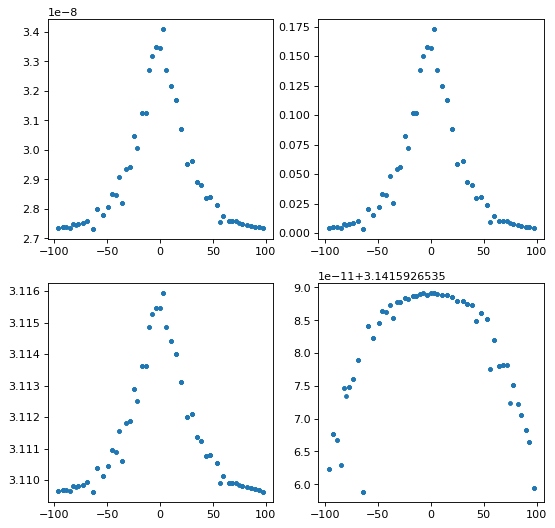

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt

nrep=1
mask=np.abs(output[:,1])<100e-9

fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
axs=ax.flatten()

output=output_unod(nodes[nind_stern,:],unod[nind_stern,0],'slab_stern.srv')
axs[0].plot(output[mask,1]*1e9,output[mask,6],'.')
axs[2].plot(output[mask,1]*1e9,output[mask,7],'.')

output=output_unod(nodes[nind_stern,:],unod[nind_stern,1],'slab_stern.srv')
axs[1].plot(output[mask,1]*1e9,output[mask,6],'.')
axs[3].plot(output[mask,1]*1e9,output[mask,7],'.')

plt.show()

Saving results to slab_water.srv.out



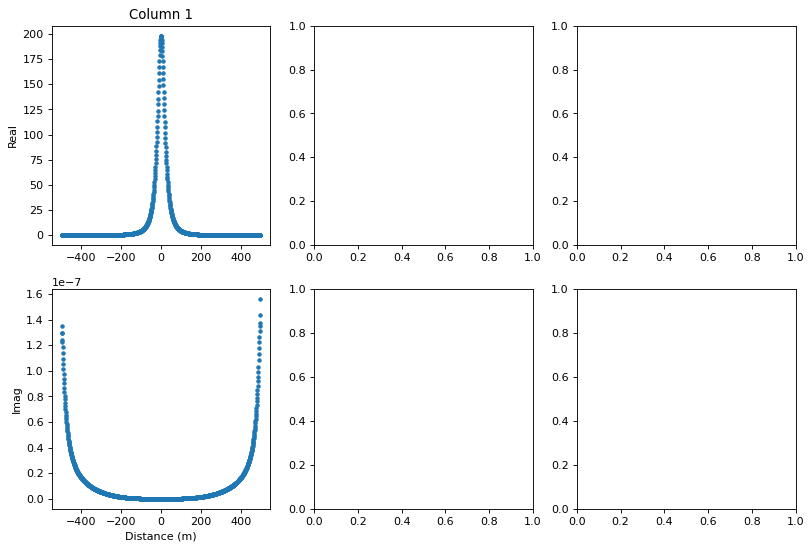

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

nrep=1

fig,ax=plt.subplots(2,3,figsize=(12,8),dpi=80)
axs=ax.flatten()
for i in range(nrep):
    output=output_unod(nodes,unod[:,i],'slab_water.srv')
    
    #axs[i].plot(nodes[:,0],np.real(unod[:,i]),'.')
    axs[i].plot(output[:,1]*1e9,output[:,6],'.')
    axs[i].set_title('Column %d'%(i+1))
    axs[i].set_ylabel('Real')
    
    #axs[i+3].plot(nodes[:,0],np.imag(unod[:,i]),'.')
    axs[i+3].plot(output[:,1]*1e9,output[:,7],'.')
    axs[i+3].set_xlabel('Distance (m)')
    axs[i+3].set_ylabel('Imag')

plt.show()

In [95]:
print(output)

[[ 1.00000000e+00 -4.99000000e-07  0.00000000e+00 ...  0.00000000e+00
   4.30559212e-04  1.34918211e-07]
 [ 2.00000000e+00 -4.98000000e-07  0.00000000e+00 ...  0.00000000e+00
   8.74372122e-04  1.29522395e-07]
 [ 3.00000000e+00 -4.97000000e-07  0.00000000e+00 ...  0.00000000e+00
   1.30140478e-03  1.29337694e-07]
 ...
 [ 9.97000000e+02  4.97000000e-07  0.00000000e+00 ...  0.00000000e+00
   1.25577998e-03  1.37049507e-07]
 [ 9.98000000e+02  4.98000000e-07  0.00000000e+00 ...  0.00000000e+00
   8.25371368e-04  1.43457730e-07]
 [ 9.99000000e+02  4.99000000e-07  0.00000000e+00 ...  0.00000000e+00
   3.99659939e-04  1.56078316e-07]]


Saving results to slab_stern.srv.out

Saving results to slab_water.srv.out



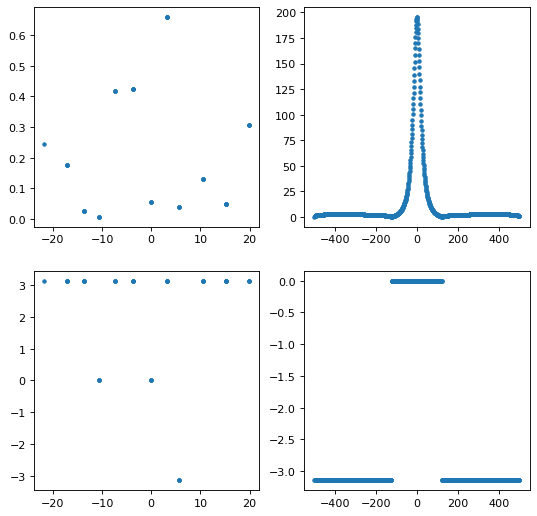

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

def output_unod(nodes,unod,srvfile):
    output=np.genfromtxt(srvfile,skip_header=1)
    rec=output[:,1:4]
    for i in range(len(rec)):
        dist2=(rec[i,0]-nodes[:,0])**2+(rec[i,1]-nodes[:,1])**2+(rec[i,2]-nodes[:,2])**2
        ind=np.argmin(dist2)
        output[i,1]=nodes[ind,0]
        output[:,2]=nodes[ind,1]
        output[:,3]=nodes[ind,2]        
        output[i,6]=np.abs(unod[ind])
        output[i,7]=np.angle(unod[ind])

    outfile=srvfile+'.out'
    fmt='%d\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e'
    print('Saving results to %s'%outfile)
    np.savetxt(outfile,output,header=str(len(output)),comments='',fmt=fmt)
    print('')
    return output

fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
axs=ax.flatten()

output=output_unod(nodes[nind_stern,:],unod[nind_stern,-1],'slab_stern.srv')
axs[0].plot(output[:,1]*1e9,output[:,6],'.')
axs[2].plot(output[:,1]*1e9,output[:,7],'.')

output=output_unod(nodes,unod[:,0],'slab_water.srv')
axs[1].plot(output[:,1]*1e9,output[:,6],'.')
axs[3].plot(output[:,1]*1e9,output[:,7],'.')

# Test Case 2 (Nrep/K11/K22)

In [59]:
if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9
    case=2
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    ansol=ansol_sphere(mesh['midpoints'],a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)

    materials2d=set_materials2d(mesh,physics,u=0,freq=0.1,case=case)
    materials3d=set_materials3d(mesh,physics,u=0,freq=0.1,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    #mesh_scale,materials3d_scale=scale_distance(mesh,materials3d,dist_factor)
    #mesh_subset,materials3d_subset=set_subdomains(mesh_scale,materials3d_scale)
    #K,b=build_system(mesh_subset,materials3d_subset,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #unod=solve_unod(K/perm0,b/perm0)
    nnode=len(nodes)
    nrep=int(len(b)/len(nodes)/2)
    unod=solve_unod(K,b)
    unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
    unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))
    
    output=output_unod(nodes,unod1[:,0],srvfile)
    u2d=grad2d(nodes,faces,unod1[:,0])
    u3d=grad3d(nodes,elements,unod1[:,0])
    np.save('sphere_s61',unod)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR STEADY STATE IS: -0.01

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Setting materials in stern layer using pre

# Test Case 3 (K12 was tested)

In [65]:
if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9
    case=3
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    ansol=ansol_sphere(mesh['midpoints'],a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)

    materials2d=set_materials2d(mesh,physics,u=0,freq=0.1,case=case)
    materials3d=set_materials3d(mesh,physics,u=0,freq=0.1,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    #mesh_scale,materials3d_scale=scale_distance(mesh,materials3d,dist_factor)
    #mesh_subset,materials3d_subset=set_subdomains(mesh_scale,materials3d_scale)
    #K,b=build_system(mesh_subset,materials3d_subset,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #unod=solve_unod(K/perm0,b/perm0)
    nnode=len(nodes)
    nrep=int(len(b)/len(nodes)/2)
    unod=solve_unod(K,b)
    unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
    unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))
    
    output=output_unod(nodes,unod1[:,0],srvfile)
    u2d=grad2d(nodes,faces,unod1[:,0])
    u3d=grad3d(nodes,elements,unod1[:,0])
    np.save('sphere_s61',unod)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR STEADY STATE IS: -0.01

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Setting materials in stern layer using pre

# Test Case 4 (K21 was tested)

In [72]:
if __name__=='__main__':
    #user input
    meshfile='sphere_s61.hdf5'
    physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9
    case=4
    
    #setup mesh and material properties
    mesh=import_mesh(meshfile)
    physics=import_physics(physfile)
    ansol=ansol_sphere(mesh['midpoints'],a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)

    materials2d=set_materials2d(mesh,physics,u=0,freq=0.1,case=case)
    materials3d=set_materials3d(mesh,physics,u=0,freq=0.1,case=case)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=case)
    #mesh_scale,materials3d_scale=scale_distance(mesh,materials3d,dist_factor)
    #mesh_subset,materials3d_subset=set_subdomains(mesh_scale,materials3d_scale)
    #K,b=build_system(mesh_subset,materials3d_subset,case=case)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    #unod=solve_unod(K/perm0,b/perm0)
    nnode=len(nodes)
    nrep=int(len(b)/len(nodes)/2)
    unod=solve_unod(K,b)
    unod1=np.reshape(unod[:nnode*nrep],(nnode,nrep))
    unod2=np.reshape(unod[nnode*nrep:],(nnode,nrep))
    
    output=output_unod(nodes,unod1[:,0],srvfile)
    u2d=grad2d(nodes,faces,unod1[:,0])
    u3d=grad3d(nodes,elements,unod1[:,0])
    np.save('sphere_s61',unod)
    print('Done')


Reading group mesh from sphere_s61.hdf5
THE NUMBER OF ACTIVE NODES IS: 24157
THE NUMBER OF ACTIVE ELEMENTS IS: 135851
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 5334
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2044

Reading group physics from sphere_s61.hdf5
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
TEMPERATURE IS: 298.0
ION COCENTRATION AT INFINITY IS: 100.0
ION VALENCE IS: 1.0
SURFACE CHARGE DENSITY FOR STEADY STATE IS: -0.01

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: -0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Setting materials in stern layer using pr

# Display Results

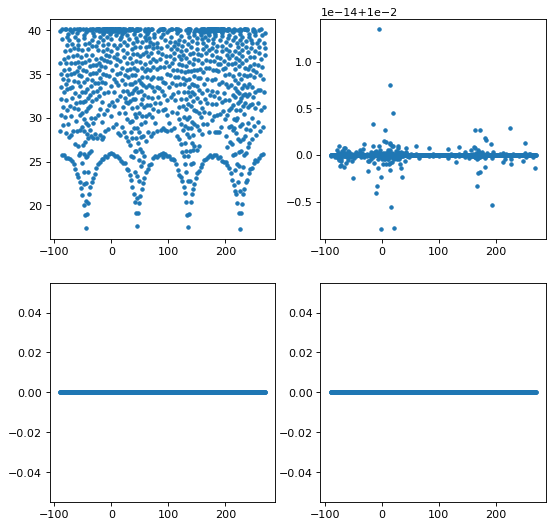

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

nrep=1
rho,theta,phi=cartesian2spherical(nodes[nind_stern,0],nodes[nind_stern,1],nodes[nind_stern,2])

fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
axs=ax.flatten()
axs[0].plot(phi*180/np.pi,np.real(unod[nind_stern,nrep-1]),'.')
axs[1].plot(phi*180/np.pi,np.real(unod[nind_stern,nrep*2-1]),'.')

axs[2].plot(phi*180/np.pi,np.imag(unod[nind_stern,nrep-1]),'.')
axs[3].plot(phi*180/np.pi,np.imag(unod[nind_stern,nrep*2-1]),'.')

plt.show()

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out



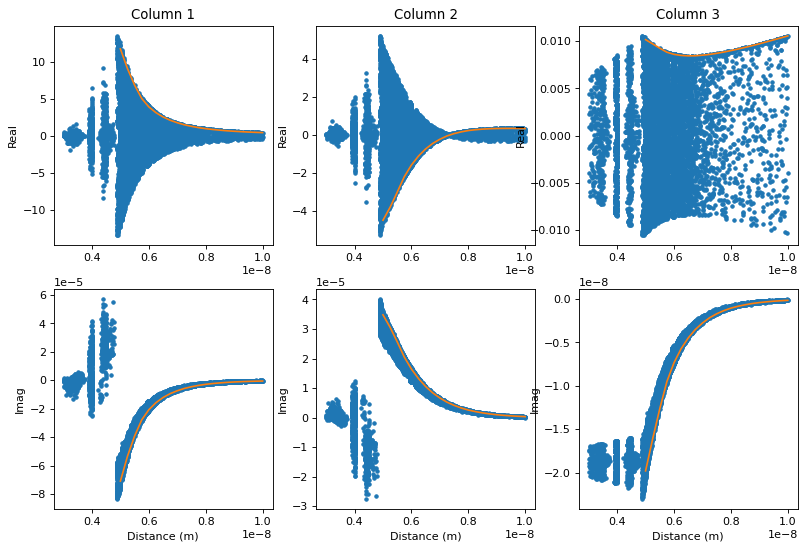

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

ansol=ansol_sphere(output[:,1:5],a=5e-9,rel_perm=78.5,temp_K=298,
                   cinf=100,zval=1,zeta=0.01,gradflag=1)

fig,ax=plt.subplots(2,3,figsize=(12,8),dpi=80)
axs=ax.flatten()

dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
mask=(dist>3e-9)&(dist<1e-8)
# mask=(dist>.1e-9)&(dist<5e-9)
for i in range(3):
    output=output_unod(nodes,unod[:,i],srvfile)
    
    axs[i].plot(dist[mask],np.real(unod[mask,i]),'.')
    #axs[i].plot(output[:,1],ansol[:,0],'*')
    axs[i].plot(output[:,1],output[:,6])
    axs[i].set_title('Column %d'%(i+1))
    axs[i].set_ylabel('Real')
    
    axs[i+3].plot(dist[mask],np.imag(unod[mask,i]),'.')
    axs[i+3].plot(output[:,1],output[:,7])
    axs[i+3].set_xlabel('Distance (m)')
    axs[i+3].set_ylabel('Imag')

plt.show()

Computing fields and field gradients in elements
Time elapsed  4.284073114395142 sec

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm



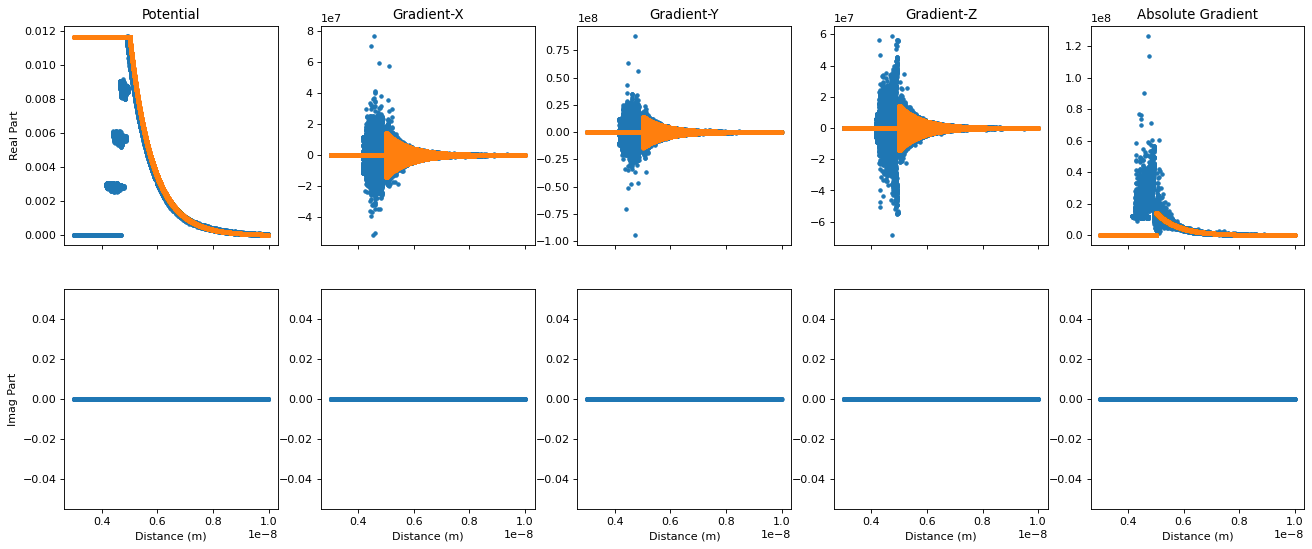

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

midpoints=compute_mids3d(nodes,elements)
dist=np.sqrt(midpoints[:,0]**2+midpoints[:,1]**2+midpoints[:,2]**2)
u3d=grad3d(nodes,elements,unod[:,0])
ansol=ansol_sphere(midpoints,a=5e-9,rel_perm=78.5,temp_K=298,
                   cinf=100,zval=1,zeta=0.01,gradflag=1)
u3d=np.append(u3d,np.asmatrix(np.sqrt(u3d[:,1]**2+u3d[:,2]**2+u3d[:,3]**2)).T,axis=1)
ansol=np.append(ansol,np.asmatrix(np.sqrt(ansol[:,1]**2+ansol[:,2]**2+ansol[:,3]**2)).T,axis=1)

fig,ax=plt.subplots(2,5,sharex=True,figsize=(20,8),dpi=80)
axs=ax.flatten()
titles=['Potential','Gradient-X','Gradient-Y','Gradient-Z','Absolute Gradient']

mask=(dist>3e-9)&(dist<1e-8)
# mask=(dist>5e-9)&(dist<1e-8)
for i in range(u3d.shape[1]):
    axs[i].plot(dist[mask],np.real(u3d[mask,i]),'.')
    axs[i].plot(dist[mask],ansol[mask,i],'.')
    axs[i].set_title(titles[i])
    
    axs[i+5].plot(dist[mask],np.imag(u3d[mask,i]),'.')
    axs[i+5].set_xlabel('Distance (m)')
    
axs[0].set_ylabel('Real Part')
axs[5].set_ylabel('Imag Part')
plt.show()